# Библиотеки

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
%%capture
!pip install phik

In [ ]:
%%capture
!pip install -U lightautoml

In [ ]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import re
from sklearn.model_selection import train_test_split
import os
import time
import requests
from sklearn.metrics import mean_squared_error
import torch
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
import optuna
from optuna.samplers import TPESampler
from lightgbm import LGBMRegressor

%matplotlib inline

warnings.filterwarnings('ignore')

In [ ]:
RANDOM_STATE = 42
N_THREADS = 4

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Постановка задачи

**Соревнование —** [Regression of Used Car Prices](https://www.kaggle.com/competitions/playground-series-s4e9/overview)

**Постановка ML-задачи —** регрессия

**Бизнес-постановка задачи:** \
Спрогнозировать цену подержанных автомобилей на основе различных характеристик

# Метрика для измерения качества

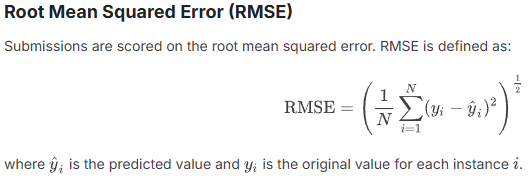

# EDA

In [ ]:
!kaggle competitions download -c playground-series-s4e9 -p data
!unzip data/playground-series-s4e9.zip -d data

  0% 0.00/7.84M [00:00<?, ?B/s]
100% 7.84M/7.84M [00:00<00:00, 879MB/s]
Archive:  data/playground-series-s4e9.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [ ]:
df = pd.read_csv('/content/data/train.csv')
df_test = pd.read_csv('/content/data/test.csv')

In [ ]:
df.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
df.shape

(188533, 13)

In [ ]:
df_test.shape

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


- `id` — уникальный идентификатор записи (объявления о продаже конкретного автомобиля)

- `brand` — марка автомобиля (производитель, например BMW, Toyota, Ford)

- `model` — модель автомобиля в рамках конкретной марки (например, Corolla, X5)

- `model_year` — год выпуска/модельный год автомобиля, важен для оценки возраста, износа и уровня технологий

- `milage` — пробег автомобиля, то есть сколько километров/миль он уже проехал, ключевой показатель износа

- `fuel_type` — тип топлива, на котором работает автомобиль (бензин, дизель, гибрид, электрический и т.п.)

- `engine` — характеристики двигателя (мощность, объём, число цилиндров и тип двигателя), влияющие на динамику и расход

- `transmission` — тип трансмиссии автомобиля (автоматическая, механическая, вариатор и другие варианты)

- `ext_col` — цвет кузова (внешний цвет автомобиля, влияющий на внешний вид и иногда ликвидность)

- `int_col` — цвет салона (внутренний цвет/отделка интерьера автомобиля)

- `accident` — информация об истории ДТП/повреждений, указывает, были ли зафиксированы аварии или ущерб

- `clean_title` — статус документа на автомобиль (чистый/повреждённый/восстановленный и т.п.)

- `price` — цена продажи подержанного автомобиля в объявлении

## Анализ целевой переменной

`price` — целевая переменная

In [ ]:
target_col = 'price'

### Численный анализ

In [134]:
df.price.describe()

,price
count,1.885330e+05
mean,4.387802e+04
std,7.881952e+04
min,2.000000e+03
25%,1.700000e+04
50%,3.082500e+04
75%,4.990000e+04
max,2.954083e+06


In [ ]:
print('\nКол-во пропусков в таргете:', df[target_col].isna().sum())
print('Кол-во нулевых значений в таргете:', (df[target_col] == 0).sum())


Кол-во пропусков в таргете: 0
Кол-во нулевых значений в таргете: 0


In [ ]:
q1, q3 = df[target_col].quantile([0.25, 0.75])
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

print(f'\nДиапазон без выбросов (IQR): [{lower_bound:.2f}, {upper_bound:.2f}]')
print('Кол-во потенциальных выбросов выше верхней границы:',
      (df[target_col] > upper_bound).sum())
print('Кол-во потенциальных выбросов ниже нижней границы:',
      (df[target_col] < lower_bound).sum())


Диапазон без выбросов (IQR): [-32350.00, 99250.00]
Кол-во потенциальных выбросов выше верхней границы: 10880
Кол-во потенциальных выбросов ниже нижней границы: 0


In [ ]:
threshold_price = df['price'].quantile(0.99)

print("Анализ экстремальных цен:")
print(f"99% перцентиль: {threshold_price}$")
print(f"Количество авто дороже {threshold_price}$: {(df['price'] > threshold_price).sum()}")

Анализ экстремальных цен:
99% перцентиль: 259500.0$
Количество авто дороже 259500.0$: 1840


### Визуализация статистик

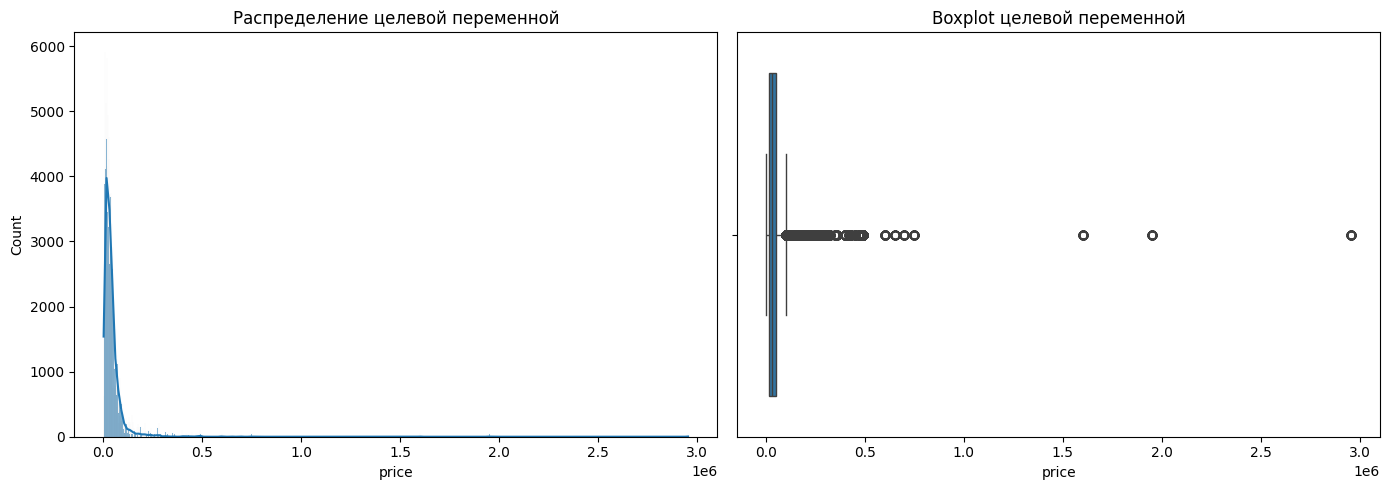

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df[target_col], kde=True)
plt.title('Распределение целевой переменной')

plt.subplot(1, 2, 2)
sns.boxplot(x=df[target_col])
plt.title('Boxplot целевой переменной')

plt.tight_layout()
plt.show()

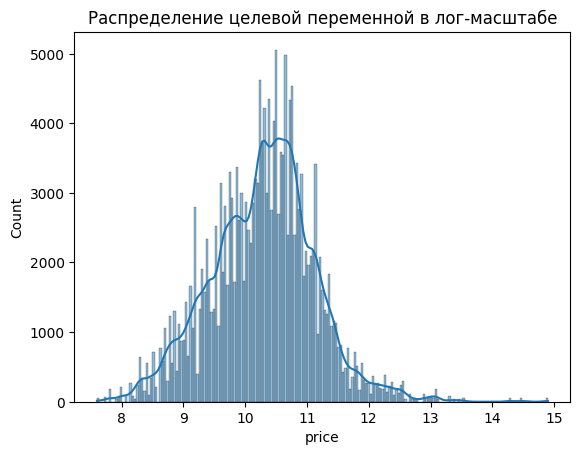

In [ ]:
sns.histplot(np.log1p(df['price']), kde=True)
plt.title('Распределение целевой переменной в лог‑масштабе')
plt.show()

Распределение `price` сильно правосторонне скошено: много недорогих машин и длинный хвост дорогих. \
Логарифмирование `log1p(price)` сжимает правый хвост: цены дорогих авто становятся ближе к значениям основной массы наблюдений, и распределение выглядит более симметричным.

## Анализ признаков

### Типизация признаков и их распределения

In [111]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(['price', 'id']).tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Числовые признаки:", numeric_cols)
print("Категориальные признаки:", categorical_cols)
print("\nDtypes:\n", df.dtypes)

Числовые признаки: ['model_year', 'milage']
Категориальные признаки: ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

Dtypes:
 id               int64
brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object


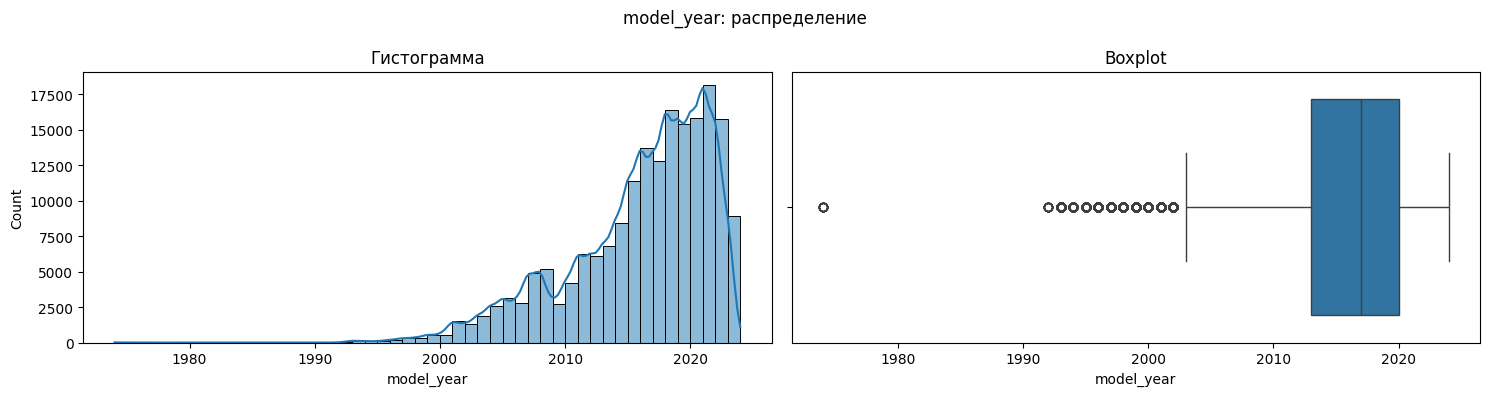

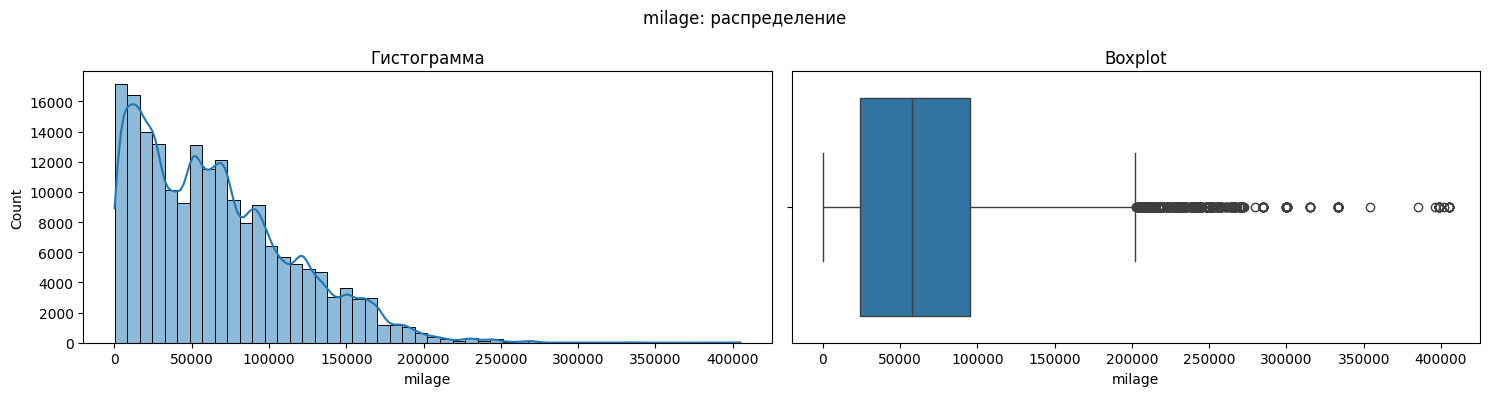

In [ ]:
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(f"{col}: распределение", fontsize=12)

    sns.histplot(df[col], bins=50, kde=True, ax=axes[0])
    axes[0].set_title("Гистограмма")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title("Boxplot")

    plt.tight_layout()
    plt.show()

По графику видно, что пробег сильно правосторонне смещён: большинство машин имеют относительно небольшой пробег, а хвост распределения тянется к очень большим значениям. На boxplot заметно много выбросов с высоким пробегом, что возможно это говорит о наличии небольшого числа сильно изношенных автомобилей.




brand: 57 уникальных значений
brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Name: count, dtype: int64


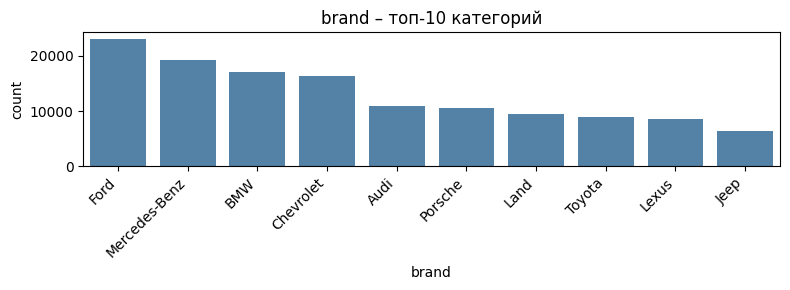


model: 1897 уникальных значений
model
F-150 XLT               2945
M3 Base                 2229
Camaro 2SS              1709
M4 Base                 1622
Mustang GT Premium      1526
F-150 Lariat            1410
E-Class E 350 4MATIC    1357
1500 Laramie            1249
911 Carrera S           1219
Corvette Base           1184
Name: count, dtype: int64


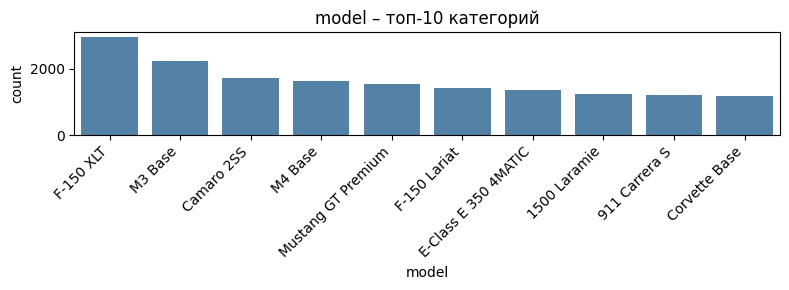


fuel_type: 7 уникальных значений
fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
NaN                 5083
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64


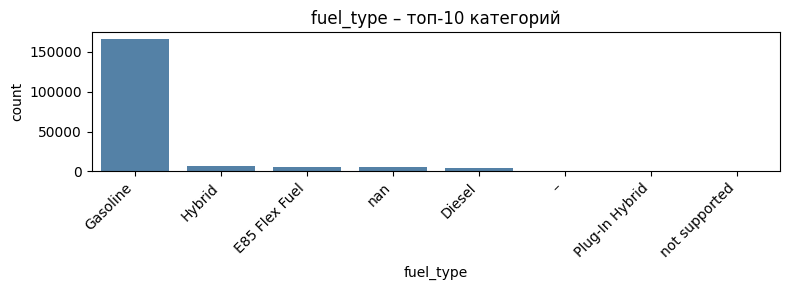


engine: 1117 уникальных значений
engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel             3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel             2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2841
2.0L I4 16V GDI DOHC Turbo                               2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            2451
340.0HP 3.0L V6 Cylinder Engine Gasoline Fuel            2436
490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2187
455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2138
425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    2134
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    2084
Name: count, dtype: int64


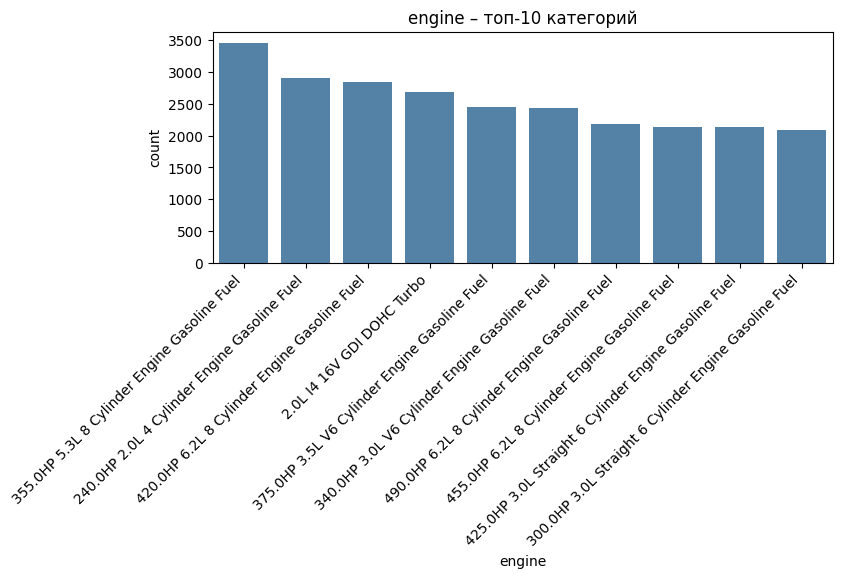


transmission: 52 уникальных значений
transmission
A/T                               49904
8-Speed A/T                       20645
Transmission w/Dual Shift Mode    19255
6-Speed A/T                       18044
6-Speed M/T                       11998
7-Speed A/T                       11124
Automatic                         10691
8-Speed Automatic                  8431
10-Speed A/T                       8044
9-Speed A/T                        3866
Name: count, dtype: int64


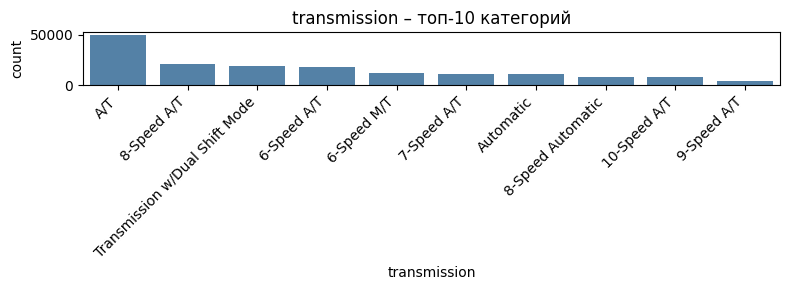


ext_col: 319 уникальных значений
ext_col
Black     48658
White     43815
Gray      25293
Silver    16995
Blue      14555
Red        9901
Green      2698
Gold       1668
Brown      1162
Orange     1139
Name: count, dtype: int64


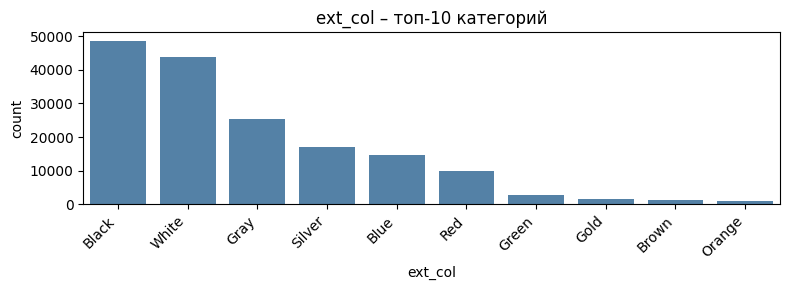


int_col: 156 уникальных значений
int_col
Black        107674
Beige         24495
Gray          21204
Brown          5810
Red            5145
White          4743
–              4527
Jet Black      2398
Ebony          1833
Orange          932
Name: count, dtype: int64


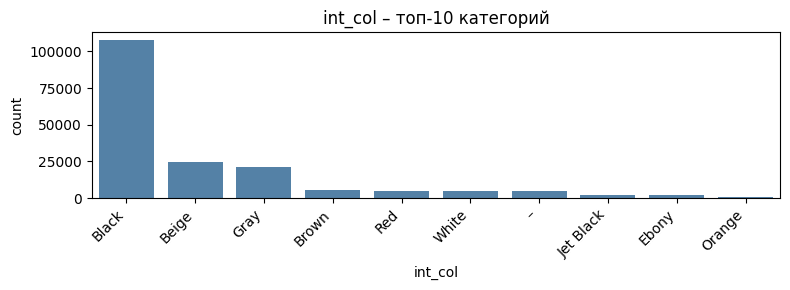


accident: 2 уникальных значений
accident
None reported                             144514
At least 1 accident or damage reported     41567
NaN                                         2452
Name: count, dtype: int64


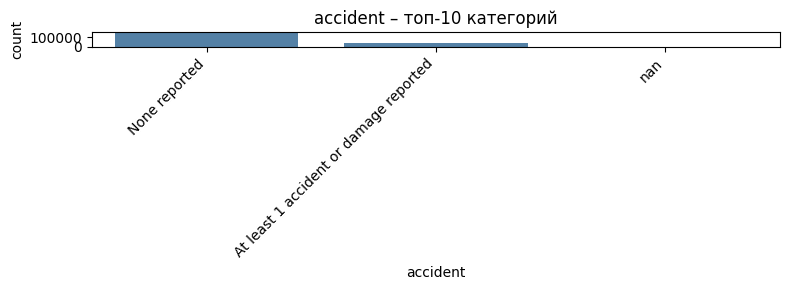


clean_title: 1 уникальных значений
clean_title
Yes    167114
NaN     21419
Name: count, dtype: int64


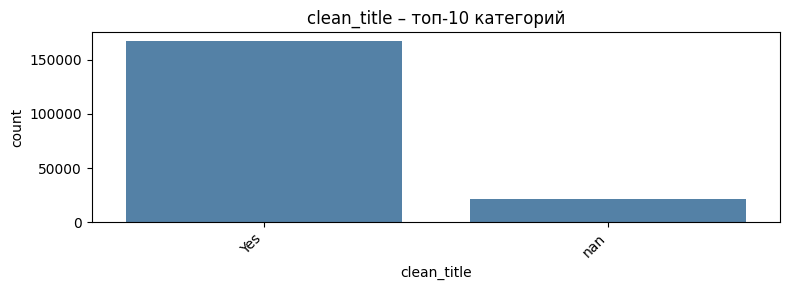

In [ ]:
for col in categorical_cols:
    vc = df[col].value_counts(dropna=False).head(10)

    print(f"\n{col}: {df[col].nunique()} уникальных значений")
    print(vc)

    plt.figure(figsize=(8, 3))
    sns.barplot(x=vc.index.astype(str), y=vc.values, color="steelblue")
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{col} – топ‑10 категорий")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

- `brand`: чаще всего встречаются автомобили марок Ford, Mercedes-Benz, BMW и Chevrolet; остальные бренды заметно менее представлены

- `model`: распределение моделей сильно разрежено, но среди топа доминируют пикапы/спорткары вроде F-150 XLT и M3 Base, остальные модели имеют значительно меньшие частоты

- `fuel_type`: подавляющее большинство автомобилей на бензине, доля гибридов, дизеля и других типов топлива значительно меньше, присутствуют пропуски

- `engine`: двигатели очень разнообразны, но чаще всего встречаются несколько типовых бензиновых моторов с разной мощностью и объёмом

- `transmission`: в данных доминируют автоматические коробки передач разных модификаций, тогда как механика встречается существенно реже

- `ext_col`: наиболее популярные цвета кузова — чёрный, белый и серый; яркие цвета (красный, синий, зелёный и т.п.) встречаются заметно реже

- `int_col`: с большим отрывом преобладает чёрный цвет салона, далее идут бежевый и серый, остальные цвета представлены значительно меньше

- `accident`: у большинства автомобилей в истории нет зарегистрированных аварий, но существенная доля имеет хотя бы одно ДТП или повреждение, плюс есть небольшое число пропусков

- `clean_title`: почти все автомобили имеют «чистый» тайтл, а часть записей содержит пропуски по этому признаку

### Выявление аномальных значений

In [139]:
for column in numeric_cols:
  print(df[column].describe(),'\n')

count    188533.000000
mean       2015.829998
std           5.660967
min        1974.000000
25%        2013.000000
50%        2017.000000
75%        2020.000000
max        2024.000000
Name: model_year, dtype: float64 

count    188533.000000
mean      65705.295174
std       49798.158076
min         100.000000
25%       24115.000000
50%       57785.000000
75%       95400.000000
max      405000.000000
Name: milage, dtype: float64 




Верхний порог пробега (99 перцентиль): 201509
Количество машин с пробегом выше порога: 1829 (0.97%)



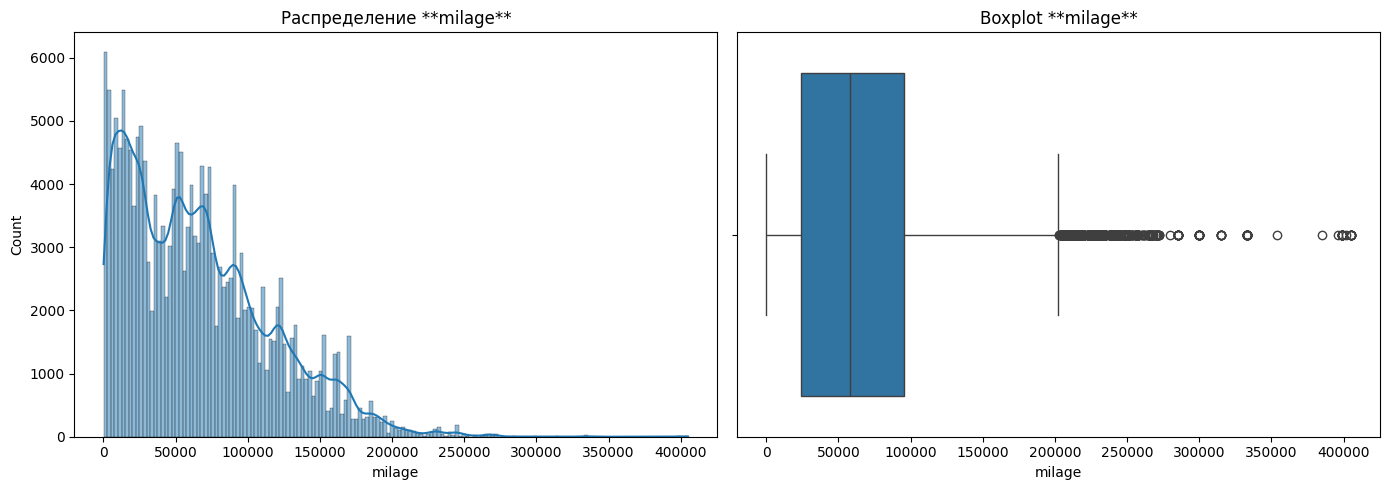

In [142]:
high_thr = df["milage"].quantile(0.99)
high_mask = df["milage"] > high_thr

print(f"\nВерхний порог пробега (99 перцентиль): {high_thr:.0f}")
print(f"Количество машин с пробегом выше порога: {high_mask.sum()} "
      f"({high_mask.mean()*100:.2f}%)\n")

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df["milage"], kde=True)
plt.title('Распределение **milage**')

plt.subplot(1, 2, 2)
sns.boxplot(x=df["milage"])
plt.title('Boxplot **milage**')

plt.tight_layout()
plt.show()

### Анализ зависимостей между признаками + графическая визуализация

**Числовые признаки и таргет**

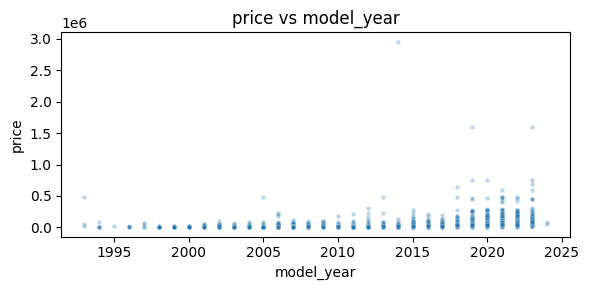

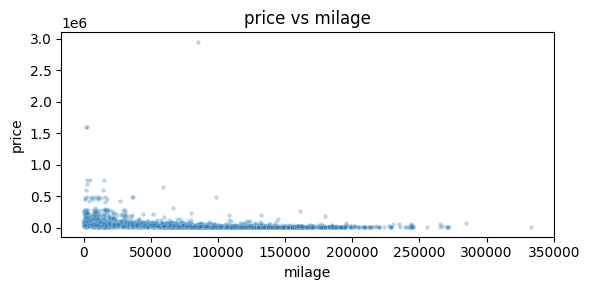

In [ ]:
sample = df.sample(min(5000, len(df)), random_state=RANDOM_STATE)

for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.scatterplot(data=sample, x=col, y=target_col, alpha=0.3, s=10)
    plt.title(f"{target_col} vs {col}")
    plt.tight_layout()
    plt.show()

По scatterplot видно, что с увеличением года выпуска и снижением пробега цена в среднем растёт, но точки сильно рассеяны вокруг тренда, поэтому связь заметно зашумлена и не является строго линейной.\
Ещё видно, что на графиках присутствует много выбросов по цене (особенно для новых и малопробежных авто), из‑за чего плотность точек у основной массы машин высокая внизу, а отдельные дорогие экземпляры сильно выбиваются вверх.

**Категориальные признаки и таргет**


brand – зависимость от таргета (топ‑5 по mean):


,mean,median,count
brand,,,
Bugatti,169600.000000,220000.0,7
Lamborghini,159176.012361,102000.0,809
Rolls-Royce,135488.650624,77500.0,561
Bentley,129272.933333,73600.0,1155
McLaren,123261.238683,87500.0,243


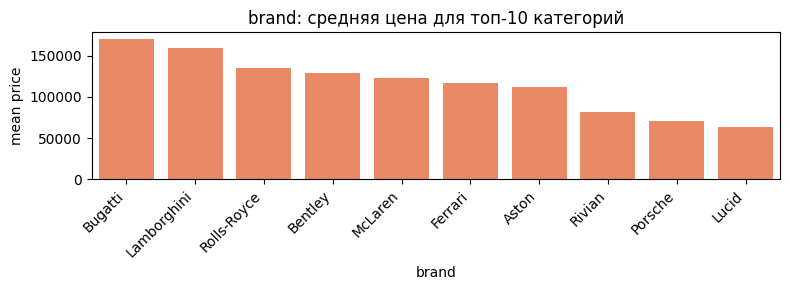


model – зависимость от таргета (топ‑5 по mean):


,mean,median,count
model,,,
Carrera GT Base,356937.250000,141500.0,8
Gallardo SE,265551.272727,142249.5,22
Phantom Drophead Coupe Drophead,250358.269231,181237.5,26
Continental GT GT Speed,244661.833333,98500.0,18
Martin DB7 Vantage Volante,229714.312500,45750.0,16


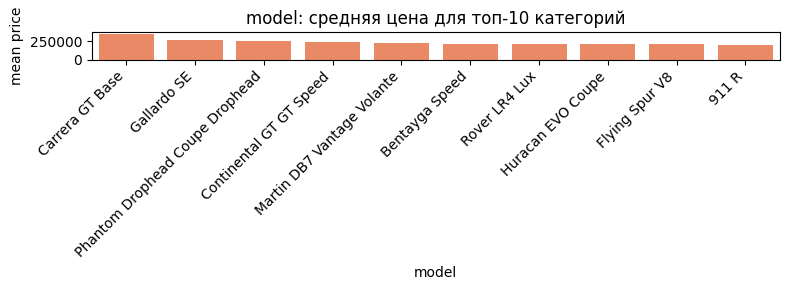


fuel_type – зависимость от таргета (топ‑5 по mean):


,mean,median,count
fuel_type,,,
Hybrid,55473.451698,44900.0,6832
Diesel,48769.587358,38500.0,3955
Plug-In Hybrid,44150.967370,38880.0,521
Gasoline,43360.013782,29999.0,165940
–,36414.285531,16250.0,781


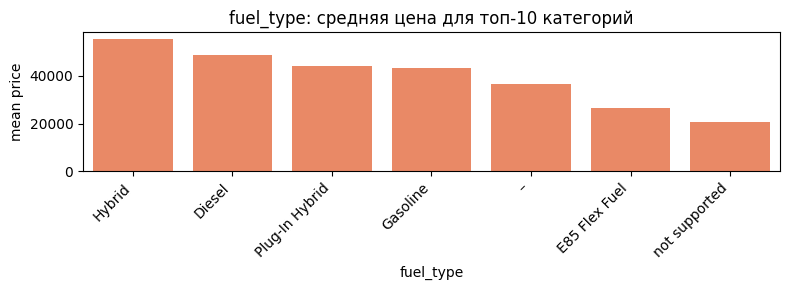


engine – зависимость от таргета (топ‑5 по mean):


,mean,median,count
engine,,,
5.3L V8 16V MPFI OHV Flexible Fuel,438810.285714,18051.0,7
6.8L V12 48V GDI DOHC,288679.888889,279925.0,18
605.0HP 5.7L 10 Cylinder Engine Gasoline Fuel,250087.538462,52000.0,13
4.0L H6 24V GDI DOHC,221396.559567,154900.0,277
6.0L W12 48V PDI DOHC Twin Turbo,210264.102190,162950.0,137


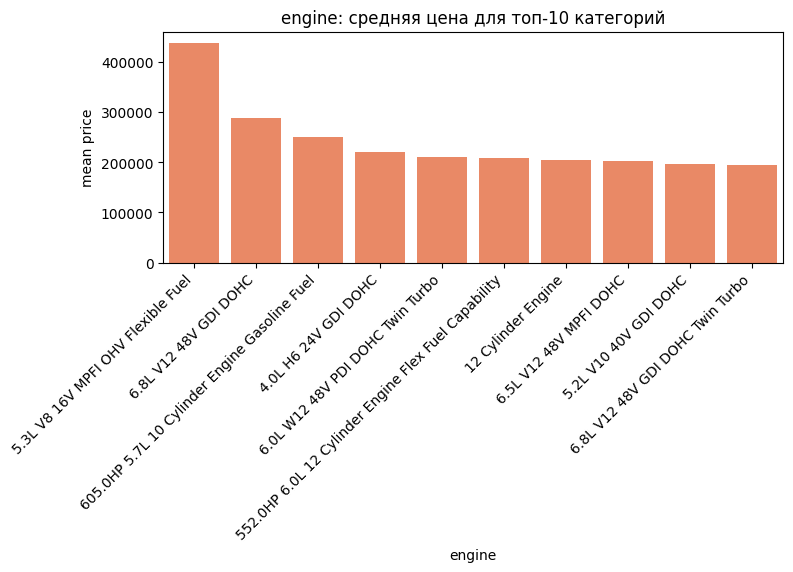


transmission – зависимость от таргета (топ‑5 по mean):


,mean,median,count
transmission,,,
7-Speed,183672.586207,132900.0,29
8-SPEED A/T,182691.000000,162500.0,7
–,159504.091954,94500.0,87
7-Speed Manual,149622.668874,116911.0,151
8-Speed Automatic with Auto-Shift,148894.349727,99950.0,549


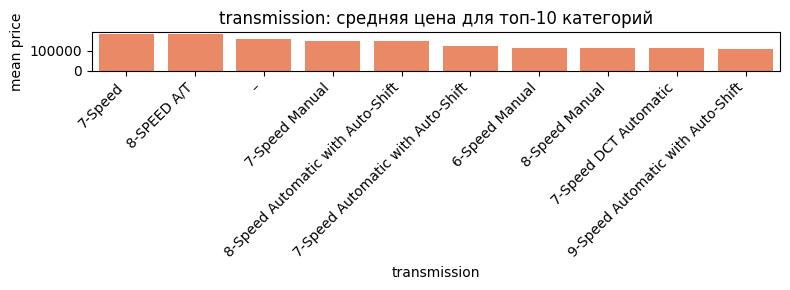


ext_col – зависимость от таргета (топ‑5 по mean):


,mean,median,count
ext_col,,,
Blue Caelum,396263.600000,52645.0,5
Dark Sapphire,355541.454545,61599.0,11
Bianco Monocerus,300063.076923,179900.0,13
C / C,292528.088235,179900.0,34
Ice,288203.272727,217950.0,33


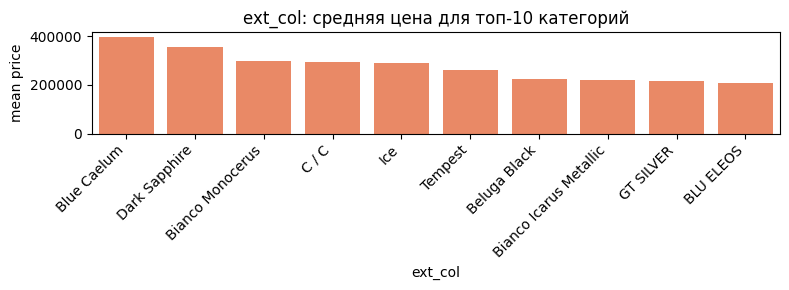


int_col – зависимость от таргета (топ‑5 по mean):


,mean,median,count
int_col,,,
Dark Auburn,268591.333333,56900.0,15
Hotspur,257780.844444,117900.0,45
Cobalt Blue,249600.666667,164475.0,6
Beluga Hide,233563.625000,196357.5,48
Linen,224166.555556,77535.0,27


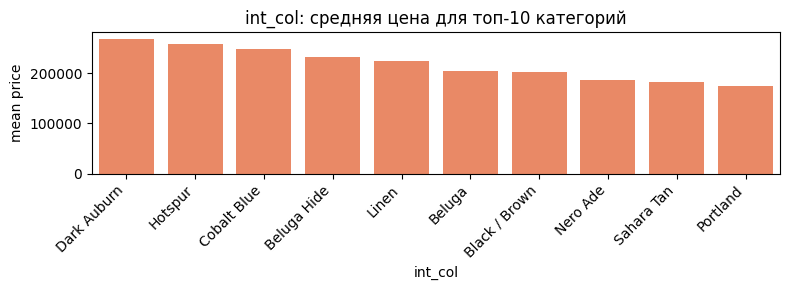


accident – зависимость от таргета (топ‑5 по mean):


,mean,median,count
accident,,,
None reported,49024.804144,35000.0,144514
At least 1 accident or damage reported,25334.071475,18000.0,41567


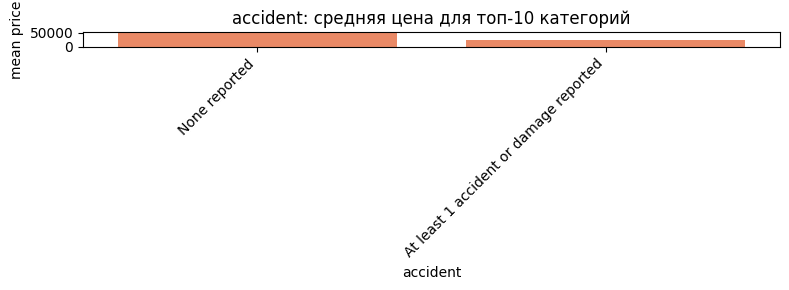


clean_title – зависимость от таргета (топ‑5 по mean):


,mean,median,count
clean_title,,,
Yes,41354.406704,29000.0,167114


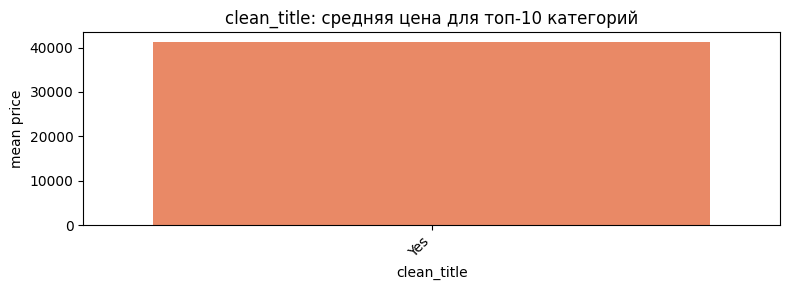

In [ ]:
for col in categorical_cols:
    stats_cat = (
        df.groupby(col)[target_col]
        .agg(["mean", "median", "count"])
        .sort_values("mean", ascending=False)
    )
    print(f"\n{col} – зависимость от таргета (топ‑5 по mean):")
    display(stats_cat.head(5))

    top = stats_cat.head(10)
    plt.figure(figsize=(8, 3))
    sns.barplot(x=top.index.astype(str), y=top["mean"], color="coral")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("mean price")
    plt.title(f"{col}: средняя цена для топ‑10 категорий")
    plt.tight_layout()
    plt.show()

- `accident`: машины без зарегистрированных аварий в среднем стоят заметно дороже, чем автомобили с хотя бы одним ДТП.

- `transmission`: самые дорогие авто связаны с продвинутыми 7‑ и 8‑ступенчатыми трансмиссиями, причём часть категорий имеет очень небольшое количество наблюдений.

- `fuel_type`: наибольшая средняя цена у гибридных и дизельных машин, тогда как бензиновые и особенно E85/другие типы топлива дешевле.

- `ext_col`: самые дорогие автомобили имеют редкие цвета кузова (например, Blue Caelum, Dark Sapphire), что отражает премиальные модели.

- `brand`: максимальные средние цены у люксовых брендов Bugatti, Lamborghini, Rolls‑Royce, Bentley и McLaren, что ожидаемо для рынка премиальных авто.

- `model`: по модели видно, что топ по средней цене занимают штучные спорткары и люксовые модификации (Carrera GT Base, Gallardo SE и др.), присутствующие в выборке в малых количествах.

- `int_col`: самые дорогие машины чаще всего имеют редкие и дорогие варианты отделки салона (например, Dark Auburn, Hotspur, Cobalt Blue), характерные для премиальных комплектаций.

- `clean_title`: автомобили с «чистым» тайтлом имеют стабильную среднюю цену, а альтернативных категорий практически нет, поэтому влияние признака в данных минимально.

### Анализ пропущенных значений

In [ ]:
df.isnull().sum()

,0
id,0
brand,0
model,0
model_year,0
milage,0
fuel_type,5083
engine,0
transmission,0
ext_col,0
int_col,0


### Определение важности признаков (корреляции с таргетом)

**Корреляция Пирсона**

Матрица корреляций (числовые + таргет):


,model_year,milage,price
model_year,1.000000,-0.669936,0.231795
milage,-0.669936,1.000000,-0.283067
price,0.231795,-0.283067,1.000000


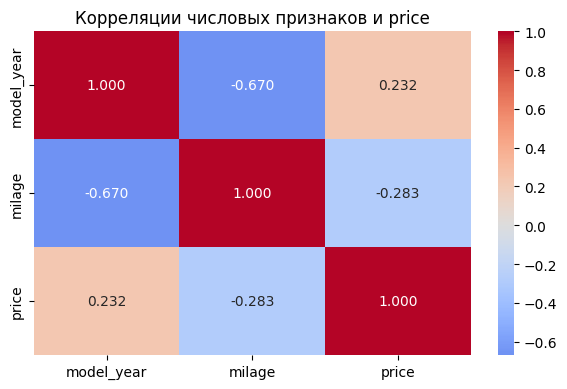

In [ ]:
pearson_corr = df[numeric_cols + [target_col]].corr()

print("Матрица корреляций (числовые + таргет):")
display(pearson_corr)

plt.figure(figsize=(6, 4))
sns.heatmap(pearson_corr, annot=True, fmt=".3f", cmap="coolwarm", center=0)
plt.title("Корреляции числовых признаков и price")
plt.tight_layout()
plt.show()

Корреляция Пирсона показывает умеренную положительную линейную связь цены с годом выпуска (r≈0.23) и слабую отрицательную с пробегом (r≈−0.28), то есть **новые машины в среднем дороже, а с ростом пробега цена несколько снижается**. При этом между годом выпуска и пробегом наблюдается сильная отрицательная линейная связь (r≈−0.67): **чем новее авто, тем, как правило, меньше его пробег**.

**Корреляция Спирмена**

Матрица корреляций (числовые + таргет):


,model_year,milage,price
model_year,1.000000,-0.738150,0.727159
milage,-0.738150,1.000000,-0.742709
price,0.727159,-0.742709,1.000000


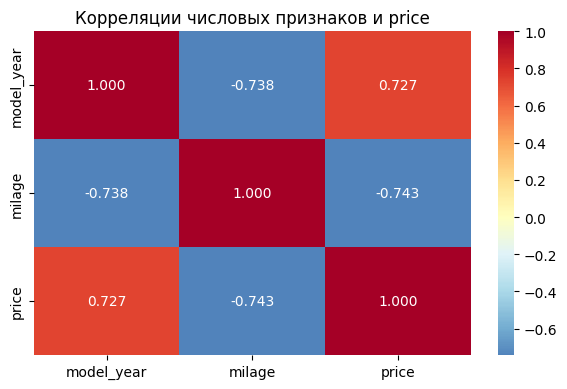

In [ ]:
spearman_corr = df[numeric_cols + [target_col]].corr(method='spearman')

print("Матрица корреляций (числовые + таргет):")
display(spearman_corr)

plt.figure(figsize=(6, 4))
sns.heatmap(spearman_corr, annot=True, fmt=".3f", cmap="RdYlBu_r", center=0)
plt.title("Корреляции числовых признаков и price")
plt.tight_layout()
plt.show()

Корреляция Спирмена показывает сильную монотонную связь цены с годом выпуска (r≈0.73) и пробегом (r≈−0.74): **чем новее машина и чем меньше пробег, тем выше цена**, и это соотношение устойчиво сохраняется при ранжировании объектов. В отличие от Пирсона, который измеряет именно линейную связь исходных значений, Спирмен считает корреляцию по рангам и лучше отражает нелинейные монотонные зависимости и менее чувствителен к выбросам.

**Phik‑корреляция**

interval columns not set, guessing: ['model_year', 'milage', 'price']


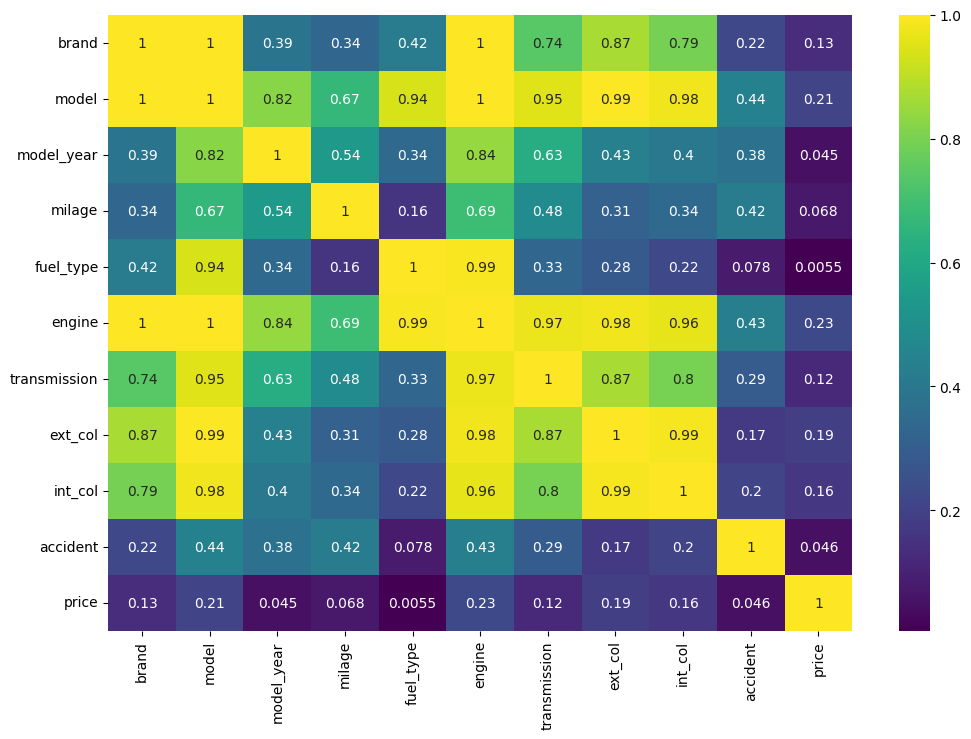

In [ ]:
plt.figure(figsize=(12, 8))

phik_matrix = df.drop(columns=['id']).phik_matrix()
sns.heatmap(phik_matrix, cmap='viridis', annot=True)

plt.show()

Phik‑корреляция показывает, насколько сильно взаимосвязаны признаки, причём одинаково хорошо работает и для числовых, и для категориальных переменных и умеет ловить нелинейные зависимости; значения ближе к 1 означают сильную зависимость, близкие к 0 — почти независимость.

### Анализ возможных преобразований и генерации новых признаков

**1. Извлечение признаков из `engine`**

In [ ]:
example_row = df.loc[
    df["engine"].str.contains("HP") &
    df["engine"].str.contains("L") &
    df["engine"].str.contains("Cylinder"),
].iloc[0]

print("Пример строки с двигателем:")
print(example_row[["brand", "model", "engine", "price"]])

Пример строки с двигателем:
brand                                             MINI
model                                    Cooper S Base
engine    172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel
price                                             4200
Name: 0, dtype: object


Внутри строки `engine` зашиты конкретные числовые характеристики (мощность в л.с., объём, число цилиндров). Такие параметры напрямую влияют на стоимость машины и гораздо удобнее для модели в виде отдельных числовых фич, чем как один длинный текст. Поэтому логично распарсить `engine` в `horsepower`, `engine_volume`, `cylinders` и отдельно аккуратно заполнить пропуски, чтобы модель могла использовать структурированную информацию вместо неструктурированных текстовых описаний.

**2. Обработка пропусков**

In [ ]:
df.isnull().sum()

,0
id,0
brand,0
model,0
model_year,0
milage,0
fuel_type,5083
engine,0
transmission,0
ext_col,0
int_col,0


In [ ]:
df_test.isnull().sum()

,0
id,0
brand,0
model,0
model_year,0
milage,0
fuel_type,3383
engine,0
transmission,0
ext_col,0
int_col,0


In [ ]:
df.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [ ]:
df.accident.unique()

array(['None reported', 'At least 1 accident or damage reported', nan],
      dtype=object)

In [ ]:
df.clean_title.unique()

array(['Yes', nan], dtype=object)

При анализе пропусков видно, что `fuel_type`, `accident`, `clean_title` содержат заметную долю `NaN`. Такая же ситуация в тестовых данных, поэтому удалять строки просто так нельзя. Предлагаю заполнять пропуски в категориальных признаках осмысленными значениями (`Unknown`, `None reported`, `No`), сохраняя все объекты.

**3. Обработка выбросов**

In [ ]:
max_price_row = df.loc[df['price'].idxmax()]
max_price_row

,220
id,220
brand,Ford
model,F-150 XLT
model_year,2021
milage,26315
fuel_type,Gasoline
engine,3.5L V6 24V PDI DOHC Twin Turbo
transmission,10-Speed Automatic
ext_col,Agate Black Metallic
int_col,Black


2954083 долларов за такой автомобиль — это нереалистично. Такой объект лучше явно отметить как аномалию и исключить из обучения.

Распределение `price` сильно скошено и имеет экстремально дорогие автомобили, которые выглядят как редкие аномалии и могут сильно влиять на обучение. Поэтому вместо удаления строк предлагается сгладить верхние выбросы по цене (через замену значений выше 99‑го перцентиля на медиану), чтобы уменьшить влияние единичных экстремальных цен на параметры модели, но при этом не терять сами объекты.

# Разделение данных

In [ ]:
# df = pd.read_csv('/content/data/train.csv')
# df_test = pd.read_csv('/content/data/test.csv')

df_train, df_val = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_STATE
)

Поскольку соревнование предоставляет отдельные тестовые данные без таргета, разделять нужно только тренировочную часть датасета на обучающую и валидационную выборки (валидационная используется для оценки качества моделей, подбора гиперпараметров).

# LAMA
(baseline)

In [ ]:
task = Task(
    'reg',
    loss='mse',
    metric='mse',
    greater_is_better=False
)

In [ ]:
target_col = 'price'

## Конфигурация 1

Используется пресет `TabularAutoML` — это классический пресет LAMA для табличных данных, который строит ансамбль из нескольких моделей и по умолчанию объединяет их предсказания взвешенным усреднением с подбором весов методом покоординатного спуска под целевую метрику.

**Параметры обучения:**
- 5-кратная кросс-валидация (cv=5)
- Ограничение времени обучения timeout = 10 минут
- Исключение идентификатора `id` через `roles = {'target': 'price', 'drop': ['id']}`
- Прочие параметры Reader задают воспроизводимость через `random_state` и уровень параллелизма через `n_jobs`

In [ ]:
N_FOLDS = 5
TIMEOUT = 60 * 10

roles_1 = {
    'target': target_col,
    'drop': ['id']
}

automl1 = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={
        'n_jobs': N_THREADS,
        'cv': N_FOLDS,
        'random_state': RANDOM_STATE,
        'stratify': False
    },
)

In [ ]:
%%time
oof_predictions_lama1 = automl1.fit_predict(df_train, roles=roles_1, verbose=1)

[16:33:48] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[16:33:48] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[16:33:48] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[16:33:48] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[16:33:48] - time: 600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 600.00 seconds


[16:33:48] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[16:33:48] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[16:33:48] Train data shape: (150826, 13)



INFO:lightautoml.reader.base:Train data shape: (150826, 13)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[16:34:00] Layer 1 train process start. Time left 588.29 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 588.29 secs


[16:34:08] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1], 'embed_sizes': array([3, 9], dtype=int32), 'data_size': 21}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -4051782144.0
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -4051782144.0
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -4051782144.0
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -5830175232.0
INFO3:lightau

[16:34:15] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -5560237056.0


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -5560237056.0


[16:34:15] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[16:34:15] Time left 573.41 secs



INFO:lightautoml.automl.base:Time left 573.41 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 4.2216e+09
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[45]	valid's l2: 4.18007e+09


[16:34:18] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[16:34:20] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.04, 'num_leaves': 64, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 2000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 4.17753e+09
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[56]	valid's l2: 4.15661e+09
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightauto

[16:34:34] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -5694800384.0


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -5694800384.0


[16:34:34] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[16:34:34] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 69.54 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 69.54 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-b6e6f756-d43f-4774-873b-f94617048f24
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 4.22064e+09
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[48]	valid's l2: 4.1778e+09
INFO:optuna.study.study:Trial 0 finished with value: -4177803264.0 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -4177803264.0.
INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperpara

[16:35:46] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6073686821752794, 'num_leaves': 22, 'bagging_fraction': 0.9982635852231622, 'min_sum_hessian_in_leaf': 0.01875620628228739, 'reg_alpha': 0.08429892082745831, 'reg_lambda': 0.06076638194380424}
 achieve -4138409984.0000 mse


[16:35:46] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 22, 'feature_fraction': 0.6073686821752794, 'bagging_fraction': 0.9982635852231622, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.08429892082745831, 'reg_lambda': 0.06076638194380424, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.01875620628228739}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 4.145e+09
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[70]	valid's l2: 4.1375

[16:35:58] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5677622784.0


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5677622784.0


[16:35:58] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[16:35:58] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 81954.7778242	test: 68618.8049134	best: 68618.8049134 (0)	total: 61.2ms	remaining: 2m 2s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 77470.1032952	test: 64356.3359186	best: 64348.4109999 (78)	total: 1.06s	remaining: 20s
I

[16:36:28] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -5693301760.0


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -5693301760.0


[16:36:28] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[16:36:28] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 208.59 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 208.59 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-0b29b938-41c8-4690-b6c6-7341151bb70c
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 81960.4970564	test: 68625.7558175	best: 68625.7558175 (0)	total: 11.5ms	remaining: 23.1s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 77756.0037093	test: 64349.0548874	best: 64348.9202732 (98)	total: 912ms	remaining: 17.1s
INFO3:lightautoml.ml_algo.boost_cb:200:	learn: 77454.7433367	test: 64364.9266240	best: 64338.6389182 (151)	total: 1.77s	remaining: 15.8s
INFO3:lightautoml.ml_algo.boost_cb:300:	learn: 77168.9402401	test: 64423.1752441	best: 64338.6389182 (151)	total: 2.63s	remaining: 14.9s
INFO3:lightautoml.ml_algo.boost_cb:400:	learn: 76961.5585768	test: 64472.9223332	best: 64338.6389182 (151)	total: 3.47s	remaining: 13

[16:39:57] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 9.868745464853832, 'min_data_in_leaf': 19}
 achieve -4137886720.0000 mse


[16:39:57] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 9.868745464853832, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 19, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 82104.8879519	test: 68790.2871006	best: 68790.2871006 (0)	total: 18.5ms	remaining: 55.5s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 78015.4031914	test: 64392.2522568	best: 64392.2522568 (100)	to

[16:40:29] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5689992704.0


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5689992704.0


[16:40:29] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[16:40:29] Time left 199.55 secs



INFO:lightautoml.automl.base:Time left 199.55 secs



[16:40:29] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[16:40:29] Blending: optimization starts with equal weights. Score = -5602467328.0000000


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = -5602467328.0000000


[16:40:29] Blending: iteration 0: score = -5526615552.0000000, weights = [0.6885298  0.10443047 0.08833333 0.         0.11870644]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -5526615552.0000000, weights = [0.6885298  0.10443047 0.08833333 0.         0.11870644]


[16:40:29] Blending: iteration 1: score = -5526260736.0000000, weights = [0.6851014  0.12029918 0.10154106 0.         0.09305838]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -5526260736.0000000, weights = [0.6851014  0.12029918 0.10154106 0.         0.09305838]


[16:40:29] Blending: iteration 2: score = -5525956608.0000000, weights = [0.6951288  0.13192488 0.1174219  0.         0.05552436]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = -5525956608.0000000, weights = [0.6951288  0.13192488 0.1174219  0.         0.05552436]


[16:40:30] Blending: iteration 3: score = -5525835776.0000000, weights = [0.66983795 0.1372057  0.13493715 0.         0.05801919]


INFO:lightautoml.automl.blend:Blending: iteration 3: score = -5525835776.0000000, weights = [0.66983795 0.1372057  0.13493715 0.         0.05801919]


[16:40:30] Blending: iteration 4: score = -5525696512.0000000, weights = [0.7096298 0.1409951 0.1493751 0.        0.       ]


INFO:lightautoml.automl.blend:Blending: iteration 4: score = -5525696512.0000000, weights = [0.7096298 0.1409951 0.1493751 0.        0.       ]


[16:40:30] Blending: best score = -5525696512.0000000, best weights = [0.7096298 0.1409951 0.1493751 0.        0.       ]


INFO:lightautoml.automl.blend:Blending: best score = -5525696512.0000000, best weights = [0.7096298 0.1409951 0.1493751 0.        0.       ]


[16:40:30] Automl preset training completed in 401.62 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 401.62 seconds



[16:40:30] Model description:
Final prediction for new objects (level 0) = 
	 0.70963 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.14100 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.14938 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.70963 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.14100 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.14938 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 



CPU times: user 10min 24s, sys: 37.9 s, total: 11min 2s
Wall time: 6min 41s


In [ ]:
print(automl1.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.70963 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.14100 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.14938 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


In [ ]:
%%time
val_pred1 = automl1.predict(df_val)

CPU times: user 4.92 s, sys: 10.6 ms, total: 4.93 s
Wall time: 2.93 s


In [ ]:
oof_rmse1 = np.sqrt(mean_squared_error(df_train[target_col], oof_pred1.data[:, 0]))
print(f'OOF RMSE: {oof_rmse1:.2f}')

val_rmse1 = np.sqrt(mean_squared_error(df_val[target_col], val_pred1.data[:, 0]))
print(f'Validation RMSE: {val_rmse1:.2f}')

OOF RMSE: 74335.03
Validation RMSE: 68512.86


## Конфигурация 2

Используется `TabularUtilizedAutoML` — пресет, который старается максимально эффективно потратить заданный timeout, чтобы за отведённое время перебрать больше настроек и комбинаций моделей.

**Параметры обучения:**
- 10-кратная кросс-валидация (cv = 10)
- Ограничение по времени: timeout = 40 минут
- Признак `id` исключён из обучения
- Явно заданы типы признаков: категориальные поля (`brand`, `model`, `fuel_type`, …) помечены как `category`, признак `engine` помечен как `text` для специальной обработки
- Задан расширенный пул алгоритмов: Linear, LightGBM, CatBoost, XGBoost и их настроенные (tuned) версии
- Указаны параметры тюнинга (лимит времени тюнинга и early stopping), чтобы улучшить качество модели в заданный срок

In [ ]:
N_FOLDS = 10
TIMEOUT = 60 * 40

roles = {
    'target': target_col,
    'drop': ['id'],
    'category': ['brand', 'model', 'fuel_type', 'transmission',
                 'ext_col', 'int_col', 'accident', 'clean_title'],
    'text': ['engine']
}

automl2 = TabularUtilizedAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    general_params={
        'use_algos': [['linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned', 'xgb', 'xgb_tuned']]
    },
    tuning_params={
        'max_tuning_time': 600,
        'early_stopping_rounds': 50
    },
    reader_params={
        'n_jobs': N_THREADS,
        'cv': N_FOLDS,
        'random_state': RANDOM_STATE,
        'stratify': False
    }
)

In [ ]:
%%time
oof_pred2 = automl2.fit_predict(df_train, roles=roles, verbose=1)

[16:40:33] Start automl utilizator with listed constraints:


INFO:lightautoml.addons.utilization.utilization:Start automl utilizator with listed constraints:


[16:40:33] - time: 2400.00 seconds


INFO:lightautoml.addons.utilization.utilization:- time: 2400.00 seconds


[16:40:33] - CPU: 4 cores


INFO:lightautoml.addons.utilization.utilization:- CPU: 4 cores


[16:40:33] - memory: 16 GB



INFO:lightautoml.addons.utilization.utilization:- memory: 16 GB



[16:40:33] If one preset completes earlier, next preset configuration will be started



INFO:lightautoml.addons.utilization.utilization:If one preset completes earlier, next preset configuration will be started



[16:40:33] ==================================================


INFO:lightautoml.addons.utilization.utilization:==================================================


[16:40:33] Start 0 automl preset configuration:


INFO:lightautoml.addons.utilization.utilization:Start 0 automl preset configuration:


[16:40:33] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}


INFO:lightautoml.addons.utilization.utilization:conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
INFO3:lightautoml.addons.utilization.utilization:Found reader_params in kwargs, need to combine
INFO3:lightautoml.addons.utilization.utilization:Merged variant for reader_params = {'n_jobs': 4, 'cv': 10, 'random_state': 42, 'stratify': False}
INFO3:lightautoml.addons.utilization.utilization:Found general_params in kwargs, need to combine
INFO3:lightautoml.addons.utilization.utilization:Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned', 'xgb', 'xgb_tuned']], 'return_all_predictions': False}


[16:40:33] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[16:40:33] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[16:40:33] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[16:40:33] - time: 2399.98 seconds


INFO:lightautoml.automl.presets.base:- time: 2399.98 seconds


[16:40:33] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[16:40:33] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[16:40:33] Train data shape: (150826, 13)



INFO:lightautoml.reader.base:Train data shape: (150826, 13)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[16:40:43] Layer 1 train process start. Time left 2390.24 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 2390.24 secs


[16:40:48] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1], 'embed_sizes': array([3, 9], dtype=int32), 'data_size': 20}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -4793734144.0
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -4788712960.0
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -4788499968.0
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -4788633088.0
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -4788633088.0
INFO2:lightautom

[16:41:07] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -5592551424.0


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -5592551424.0


[16:41:07] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[16:41:07] Time left 2366.20 secs



INFO:lightautoml.automl.base:Time left 2366.20 secs



[16:41:12] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.04, 'num_leaves': 64, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 2000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 4.72948e+09
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[93]	valid's l2: 4.72506e+09
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightauto

[16:42:12] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -5502457344.0


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -5502457344.0


[16:42:12] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[16:42:12] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 80.79 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 80.79 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-e28cdb99-a8c1-424b-bd6b-3f3c38cb03dd
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 4.74442e+09
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[85]	valid's l2: 4.73541e+09
INFO:optuna.study.study:Trial 0 finished with value: -4735409152.0 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -4735409152.0.
INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperpar

[16:43:36] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.510265104843516, 'num_leaves': 155, 'bagging_fraction': 0.7149885992524332, 'min_sum_hessian_in_leaf': 5.376638637951061, 'reg_alpha': 0.005764962972197542, 'reg_lambda': 0.03969950572380484}
 achieve -4689044992.0000 mse


[16:43:36] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 155, 'feature_fraction': 0.510265104843516, 'bagging_fraction': 0.7149885992524332, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.005764962972197542, 'reg_lambda': 0.03969950572380484, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 5.376638637951061}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 4.7338e+09
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[72]	valid's l2: 4.7149

[16:44:30] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5486426624.0


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5486426624.0


[16:44:30] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[16:44:30] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 79963.7865951	test: 73907.6479836	best: 73907.6479836 (0)	total: 46.1ms	remaining: 1m 32s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 73298.4799513	test: 68742.6467542	best: 68742.6467542 (100)	total: 2.08s	remaining: 39.

[16:45:58] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -5501865984.0


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -5501865984.0


[16:45:58] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[16:45:58] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 580.51 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 580.51 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-3ca276fc-5a94-485f-8e64-8338267b2e85
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 79974.8221235	test: 73916.6643061	best: 73916.6643061 (0)	total: 36.4ms	remaining: 1m 12s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 73915.2398300	test: 68745.6270253	best: 68745.6270253 (100)	total: 2.41s	remaining: 45.4s
INFO3:lightautoml.ml_algo.boost_cb:200:	learn: 73202.6824052	test: 68679.2100646	best: 68676.3007166 (184)	total: 3.62s	remaining: 32.4s
INFO3:lightautoml.ml_algo.boost_cb:300:	learn: 72597.1448340	test: 68672.2428562	best: 68655.5342600 (235)	total: 4.84s	remaining: 27.3s
INFO3:lightautoml.ml_algo.boost_cb:400:	learn: 71788.7623777	test: 68698.4464171	best: 68655.5342600 (235)	total: 6.04s	remaining: 

[16:55:45] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.2306486218799266, 'min_data_in_leaf': 4}
 achieve -4699903488.0000 mse


[16:55:45] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 3.2306486218799266, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'min_data_in_leaf': 4, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 80155.0571083	test: 74067.0784837	best: 74067.0784837 (0)	total: 25.2ms	remaining: 1m 15s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 74236.6844208	test: 68759.0045948	best: 68759.0045948 (100)	t

[16:57:40] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5491961344.0


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5491961344.0


[16:57:40] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[16:57:40] Start fitting Lvl_0_Pipe_1_Mod_4_XGBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_4_XGBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'n_estimators': 3000, 'early_stopping_rounds': 100, 'seed': 42, 'verbose_eval': 100, 'nthread': 2}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_4_XGBoost =====
INFO3:lightautoml.ml_algo.boost_xgb:[0]	valid-rmse:71599.29101
INFO3:lightautoml.ml_algo.boost_xgb:[100]	valid-rmse:69951.17061
INFO3:lightautoml.ml_algo.boost_xgb:[105]	valid-rmse:69953.27258
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_4_XGBoost =====
INFO3:lightautoml.ml_algo.boost_xgb:[0]	valid-rmse:60119.84191
INFO3:lightautoml.ml_algo.boost_xgb:[100]	valid-rmse:60709.21777
INFO3:lightautoml.ml_algo.boost_xgb:[103]	valid-rmse:60749.04929
INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_4_XGBoost =====
INFO3:lightautoml.ml_algo.boost_xgb:[0]	valid-rmse:82816.66789
INFO3:lightautoml.ml_algo.bo

[16:58:05] Fitting Lvl_0_Pipe_1_Mod_4_XGBoost finished. score = -5955173376.0


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_4_XGBoost finished. score = -5955173376.0


[16:58:05] Lvl_0_Pipe_1_Mod_4_XGBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_4_XGBoost fitting and predicting completed


[16:58:05] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost ... Time budget is 600.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost ... Time budget is 600.00 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-6c2a11e2-05cf-4604-bdfb-773fdb1bce96
INFO3:lightautoml.ml_algo.boost_xgb:[0]	valid-rmse:74208.86090
INFO3:lightautoml.ml_algo.boost_xgb:[100]	valid-rmse:68874.57511
INFO3:lightautoml.ml_algo.boost_xgb:[200]	valid-rmse:68423.85380
INFO3:lightautoml.ml_algo.boost_xgb:[300]	valid-rmse:68356.57196
INFO3:lightautoml.ml_algo.boost_xgb:[400]	valid-rmse:68339.67576
INFO3:lightautoml.ml_algo.boost_xgb:[500]	valid-rmse:68352.41554
INFO3:lightautoml.ml_algo.boost_xgb:[506]	valid-rmse:68354.08039
INFO:optuna.study.study:Trial 0 finished with value: -4672485888.0 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'max_depth': 17, 'learning_rate': 0.016, 'min_child_weight': 178, 'reg_alpha': 0.00153391625911636

[17:08:13] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'colsample_bytree': 0.3, 'subsample': 1.0, 'max_depth': 9, 'learning_rate': 0.016, 'min_child_weight': 66, 'reg_alpha': 9.933740735791455, 'reg_lambda': 0.002420888131307643}
 achieve -4667906048.0000 mse


[17:08:13] Start fitting Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'n_estimators': 3000, 'early_stopping_rounds': 100, 'seed': 42, 'verbose_eval': 100, 'nthread': 2, 'colsample_bytree': 0.3, 'subsample': 1.0, 'max_depth': 9, 'learning_rate': 0.016, 'min_child_weight': 66, 'reg_alpha': 9.933740735791455, 'reg_lambda': 0.002420888131307643}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost =====
INFO3:lightautoml.ml_algo.boost_xgb:[0]	valid-rmse:74203.59482
INFO3:lightautoml.ml_algo.boost_xgb:[100]	valid-rmse:69023.72545
INFO3:lightautoml.ml_algo.boost_xgb:[200]	valid-rmse:68511.73166
INFO3:lightautoml.ml_algo.boost_xgb:[300]	valid-rmse:68396.34891
INFO3:lightautoml.ml_algo.boost_xgb:[400]	valid-rmse:68343.44835
INFO3:lightautoml.ml_algo.boost_xgb:[500]	valid-rmse:68307.52650
INFO3:lightautoml.ml_algo.boost_xgb:[600]	valid-rmse:68314.33972
INFO3:lightautoml.ml_algo.boost_xgb:[

[17:11:06] Fitting Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost finished. score = -5459526144.0


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost finished. score = -5459526144.0


[17:11:06] Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost fitting and predicting completed


[17:11:06] Time left 567.46 secs



INFO:lightautoml.automl.base:Time left 567.46 secs



[17:11:06] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[17:11:06] Blending: optimization starts with equal weights. Score = -5458336768.0000000


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = -5458336768.0000000


[17:11:06] Blending: iteration 0: score = -5448301056.0000000, weights = [0.         0.07604659 0.21600096 0.12046882 0.09081977 0.05045206
 0.4462117 ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -5448301056.0000000, weights = [0.         0.07604659 0.21600096 0.12046882 0.09081977 0.05045206
 0.4462117 ]


[17:11:06] Blending: iteration 1: score = -5447814656.0000000, weights = [0.         0.         0.25661087 0.10562281 0.08942096 0.06071726
 0.48762813]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -5447814656.0000000, weights = [0.         0.         0.25661087 0.10562281 0.08942096 0.06071726
 0.48762813]


[17:11:07] Blending: iteration 2: score = -5447802880.0000000, weights = [0.         0.         0.24972261 0.11581855 0.08577153 0.06133172
 0.4873556 ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = -5447802880.0000000, weights = [0.         0.         0.24972261 0.11581855 0.08577153 0.06133172
 0.4873556 ]


[17:11:07] Blending: iteration 3: score = -5447802368.0000000, weights = [0.         0.         0.24858025 0.11909918 0.08548246 0.06112502
 0.48571312]


INFO:lightautoml.automl.blend:Blending: iteration 3: score = -5447802368.0000000, weights = [0.         0.         0.24858025 0.11909918 0.08548246 0.06112502
 0.48571312]


[17:11:08] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[17:11:08] Blending: best score = -5447802368.0000000, best weights = [0.         0.         0.24858025 0.11909918 0.08548246 0.06112502
 0.48571312]


INFO:lightautoml.automl.blend:Blending: best score = -5447802368.0000000, best weights = [0.         0.         0.24858025 0.11909918 0.08548246 0.06112502
 0.48571312]


[17:11:08] Automl preset training completed in 1834.76 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 1834.76 seconds



[17:11:08] Model description:
Final prediction for new objects (level 0) = 
	 0.24858 * (10 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.11910 * (10 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.08548 * (10 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) +
	 0.06113 * (10 averaged models Lvl_0_Pipe_1_Mod_4_XGBoost) +
	 0.48571 * (10 averaged models Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.24858 * (10 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.11910 * (10 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.08548 * (10 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) +
	 0.06113 * (10 averaged models Lvl_0_Pipe_1_Mod_4_XGBoost) +
	 0.48571 * (10 averaged models Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost) 



[17:11:08] ==================================================


INFO:lightautoml.addons.utilization.utilization:==================================================


CPU times: user 48min 18s, sys: 1min 30s, total: 49min 48s
Wall time: 30min 34s


In [ ]:
print(automl2.create_model_str_desc())

Final prediction for new objects = 
	1.00000 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.24858 * (10 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.11910 * (10 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.08548 * (10 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) +
			 0.06113 * (10 averaged models Lvl_0_Pipe_1_Mod_4_XGBoost) +
			 0.48571 * (10 averaged models Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost) 





In [ ]:
%%time
val_pred2 = automl2.predict(df_val)

CPU times: user 26.7 s, sys: 23 ms, total: 26.8 s
Wall time: 15.3 s


In [ ]:
oof_rmse2 = np.sqrt(mean_squared_error(df_train[target_col], oof_pred2.data[:, 0]))
print(f'OOF RMSE: {oof_rmse2:.2f}')

val_rmse2 = np.sqrt(mean_squared_error(df_val[target_col], val_pred2.data[:, 0]))
print(f'Validation RMSE: {val_rmse2:.2f}')

OOF RMSE: 73809.23
Validation RMSE: 68041.68


## Выбор лучшего решения

In [109]:
models = {
    'TabularAutoML': automl1,
    'TabularUtilizedAutoML': automl2,
}

for name, model in models.items():
    test_pred = model.predict(df_test)

    predictions = test_pred.data[:, 0]

    submission = pd.DataFrame({
        'id': df_test['id'].reset_index(drop=True),
        'price': predictions.flatten()
    })

    submission.to_csv(f'submission_{name}.csv', index=False)

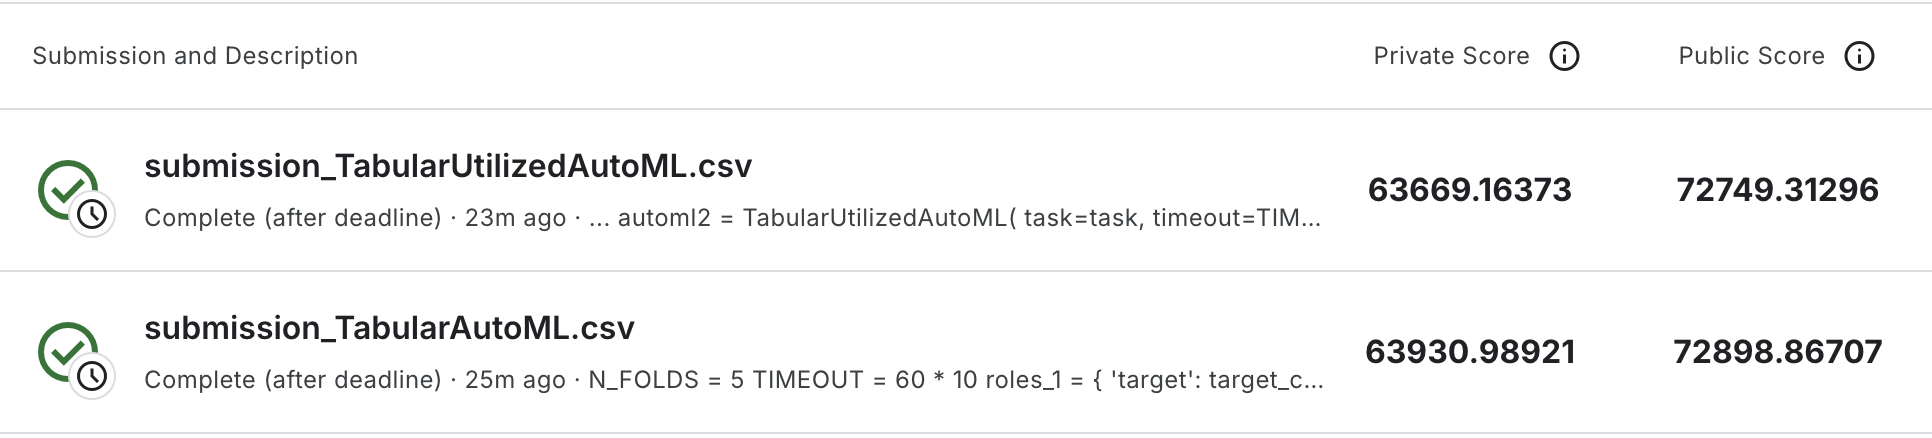

Конфигурация 1 — быстрый baseline, Конфигурация 2 — основной финальный вариант (дольше считается, но даёт лучший скор и на локальной проверке, и на лидерборде)

# Preprocessing

In [119]:
print("Количество уникальных значений в категориальных признаках:\n")
for feature in categorical_cols:
    unique_values = df_train[feature].unique()
    unique_count = len(unique_values)
    print(f"{feature}: {unique_count} уникальных значений")

    if unique_count > 10:
        top5 = df_train[feature].value_counts().head(5).to_dict()
        print(f"  Топ-5: {top5}\n")
    else:
        print(f"  Уникальные значения: {list(unique_values)}\n")

Количество уникальных значений в категориальных признаках:

brand: 57 уникальных значений
  Топ-5: {'Ford': 18497, 'Mercedes-Benz': 15390, 'BMW': 13631, 'Chevrolet': 13100, 'Audi': 8671}

model: 1897 уникальных значений
  Топ-5: {'F-150 XLT': 2357, 'M3 Base': 1806, 'Camaro 2SS': 1366, 'M4 Base': 1305, 'Mustang GT Premium': 1255}

fuel_type: 8 уникальных значений
  Уникальные значения: ['E85 Flex Fuel', 'Gasoline', 'Hybrid', 'Diesel', nan, '–', 'Plug-In Hybrid', 'not supported']

engine: 1117 уникальных значений
  Топ-5: {'355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel': 2778, '240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel': 2334, '420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel': 2277, '2.0L I4 16V GDI DOHC Turbo': 2120, '375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel': 1950}

transmission: 52 уникальных значений
  Топ-5: {'A/T': 39876, '8-Speed A/T': 16489, 'Transmission w/Dual Shift Mode': 15407, '6-Speed A/T': 14425, '6-Speed M/T': 9647}

ext_col: 319 уникальных значений
  Топ-5: {'Black':

In [120]:
nominal_features_te = ['brand', 'transmission', 'ext_col', 'int_col']
nominal_features_ohe = ['fuel_type']
numeric_features_base = ['model_year', 'milage']
numeric_features_engine = ['horsepower', 'engine_volume', 'cylinders']
numeric_features = numeric_features_base + numeric_features_engine

In [121]:
binary_mapping = {
    'accident': ('At least 1 accident or damage reported', 'None reported'),
    'clean_title': ('Yes', 'No')
}

**TargetEncoder для `['brand', 'transmission', 'ext_col', 'int_col']`**\
У этих признаков десятки–сотни уникальных значений: `brand` (57), `transmission` (52), `ext_col` (319), `int_col` (156). One-hot для них дал бы сотни колонок и сильно разреженную матрицу. TargetEncoder позволяет сжать каждый такой признак в один числовой столбец, используя связь категории с таргетом.

**OneHotEncoder для `['fuel_type']`**\
У `fuel_type` всего 8 уникальных значений, поэтому one-hot даёт всего несколько бинарных колонок без взрыва размерности.

**BinaryEncoder для `['clean_title', 'accident']`**\
После обработки эти признаки фактически бинарные (2 состояния каждый), поэтому достаточно закодировать их как 0/1.

In [122]:
class EngineFeatureExtractor(BaseEstimator, TransformerMixin):
    """Извлекает HP, объем двигателя, количество цилиндров из колонки engine"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        def extract_horsepower(engine_str):
            if pd.isna(engine_str):
                return np.nan
            patterns = [r'(\d+\.?\d*)HP', r'(\d+\.?\d*)\s*HP', r'(\d+)\s*hp']
            for pattern in patterns:
                match = re.search(pattern, engine_str, re.IGNORECASE)
                if match:
                    return float(match.group(1))
            return np.nan

        def extract_engine_volume(engine_str):
            if pd.isna(engine_str):
                return np.nan
            patterns = [r'(\d+\.?\d*)L', r'(\d+\.?\d*)\s*L', r'(\d+\.?\d*)\s*Liter']
            for pattern in patterns:
                match = re.search(pattern, engine_str, re.IGNORECASE)
                if match:
                    return float(match.group(1))
            return np.nan

        def extract_cylinders(engine_str):
            if pd.isna(engine_str):
                return np.nan
            patterns = [r'(\d+)\s*Cylinder', r'(\d+)\.?[0-9]*\s*Cyl', r'[VI](\d+)', r'(\d+)\s*cyl']
            for pattern in patterns:
                match = re.search(pattern, engine_str, re.IGNORECASE)
                if match:
                    return int(match.group(1))
            return np.nan

        X['horsepower'] = X['engine'].apply(extract_horsepower)
        X['engine_volume'] = X['engine'].apply(extract_engine_volume)
        X['cylinders'] = X['engine'].apply(extract_cylinders)

        X['horsepower'] = X['horsepower'].fillna(-1)
        X['engine_volume'] = X['engine_volume'].fillna(-1)
        X['cylinders'] = X['cylinders'].fillna(-1)

        return X


class MissingValueFiller(BaseEstimator, TransformerMixin):
    """Заполняет пропуски в категориальных признаках"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['fuel_type'] = X['fuel_type'].fillna('Unknown')
        X.loc[X['fuel_type'] == '–', 'fuel_type'] = 'Unknown'
        X['accident'] = X['accident'].fillna('None reported')
        X['clean_title'] = X['clean_title'].fillna('No')
        return X


class OutlierClipper(BaseEstimator, TransformerMixin):
    """Обрезает выбросы в цене (используется только при обучении)"""

    def __init__(self, quantile=0.99):
        self.quantile = quantile
        self.threshold = None
        self.median = None

    def fit(self, X, y=None):
        if y is not None:
            self.threshold = y.quantile(self.quantile)
            self.median = y.median()
        return self

    def transform(self, X):
        if self.threshold is not None and 'price' in X.columns:
            X = X.copy()
            X.loc[X['price'] > self.threshold, 'price'] = self.median
        return X


class BinaryEncoder(BaseEstimator, TransformerMixin):
    """Конвертирует бинарные признаки в 0/1"""

    def __init__(self, columns_mapping):
        self.columns_mapping = columns_mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col, (true_val, false_val) in self.columns_mapping.items():
            X[col] = X[col].apply(lambda x: 1 if x == true_val else 0)
        return X

 Пайплайн предобработки:\
\
 **1) Извлечение параметров двигателя и заполнение пропусков**  
   Сначала `EngineFeatureExtractor` парсит текстовый столбец `engine` и добавляет новые числовые признаки: мощность (`horsepower`), объём двигателя (`engine_volume`) и число цилиндров (`cylinders`) с заменой пропусков на -1; затем `MissingValueFiller` заполняет пропуски и некорректные значения в `fuel_type`, `accident` и `clean_title`.\
   \
**2) Обработка выбросов по целевой переменной**  
   Трансформер `OutlierClipper` при обучении находит порог по верхнему квантилю цены (по умолчанию 0.99) и заменяет значения `price` выше этого порога на медиану, сглаживая сильные выбросы.\
   \
**3) Кодирование бинарных признаков**  
   `BinaryEncoder` переводит выбранные бинарные категориальные признаки в формат 0/1 на основе переданного словаря соответствий.\
   \
**4) Кодирование категориальных и масштабирование числовых признаков**  
   Через `ColumnTransformer` выполняется таргет‑кодирование (`TargetEncoder`) части номинальных признаков (`nominal_features_te`), one-hot-кодирование (`OneHotEncoder`) остальных категориальных признаков (`nominal_features_ohe`, включая `fuel_type`), а числовые признаки (`numeric_features`, в том числе новые признаки двигателя) нормализуются с помощью `StandardScaler`.


In [126]:
engine_extractor = EngineFeatureExtractor()
missing_filler = MissingValueFiller()
outlier_clipper = OutlierClipper(quantile=0.99)
binary_encoder = BinaryEncoder(binary_mapping)
target_encoder = TargetEncoder(smooth='auto', target_type='continuous')
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

column_transformer = ColumnTransformer([
    ('target_enc', target_encoder, nominal_features_te),
    ('ohe', ohe, nominal_features_ohe),
    ('scaler', scaler, numeric_features),
], remainder='drop')

preprocessing_pipeline = Pipeline([
    ('step_1_engine_extraction', engine_extractor),
    ('step_2_missing_fill', missing_filler),
    ('step_3_outlier_clip', outlier_clipper),
    ('step_4_binary_encode', binary_encoder),
    ('step_5_column_transform', column_transformer),
])

In [127]:
X_train = df_train.drop(target_col, axis=1)
X_train_processed = preprocessing_pipeline.fit_transform(
    X_train,
    y=df_train[target_col]
)

X_val = df_val.drop(target_col, axis=1)
X_val_processed = preprocessing_pipeline.transform(X_val)

X_test = preprocessing_pipeline.transform(df_test)

y_train = df_train[target_col].values

y_val = df_val[target_col].values

# LightGBM + Optuna

В качестве основной модели использован LightGBM, так как градиентный бустинг по деревьям даёт более высокое качество на табличной регрессии и обучается заметно быстрее, чем классический GradientBoosting, RandomForest и XGBoost на CPU.

In [128]:
def objective(trial):
    """
    Функция, которую оптимизирует Optuna.
    trial — объект, который генерирует гиперпараметры
    """

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': RANDOM_STATE,
        'verbose': -1,
    }

    try:
        model = LGBMRegressor(**params)
        model.fit(X_train_processed, y_train)
        y_val_pred = model.predict(X_val_processed)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        return rmse
    except:
        return float('inf')

In [129]:
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

[I 2025-12-13 22:21:52,971] A new study created in memory with name: no-name-31e00502-1734-47de-a2cf-7f1c2c82b95c
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-31e00502-1734-47de-a2cf-7f1c2c82b95c


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:optuna.study.study:Trial 0 finished with value: 67980.52103610842 and parameters: {'n_estimators': 50, 'learning_rate': 0.048076209175745496, 'max_depth': 11, 'num_leaves': 53, 'min_child_samples': 13, 'subsample': 0.8997815699360481, 'colsample_bytree': 0.9482139007870923}. Best is trial 0 with value: 67980.52103610842.


[I 2025-12-13 22:21:54,785] Trial 0 finished with value: 67980.52103610842 and parameters: {'n_estimators': 50, 'learning_rate': 0.048076209175745496, 'max_depth': 11, 'num_leaves': 53, 'min_child_samples': 13, 'subsample': 0.8997815699360481, 'colsample_bytree': 0.9482139007870923}. Best is trial 0 with value: 67980.52103610842.


INFO:optuna.study.study:Trial 1 finished with value: 73296.84606391843 and parameters: {'n_estimators': 100, 'learning_rate': 0.001335045757789584, 'max_depth': 7, 'num_leaves': 55, 'min_child_samples': 10, 'subsample': 0.747110695758854, 'colsample_bytree': 0.6058782948987258}. Best is trial 0 with value: 67980.52103610842.


[I 2025-12-13 22:21:55,872] Trial 1 finished with value: 73296.84606391843 and parameters: {'n_estimators': 100, 'learning_rate': 0.001335045757789584, 'max_depth': 7, 'num_leaves': 55, 'min_child_samples': 10, 'subsample': 0.747110695758854, 'colsample_bytree': 0.6058782948987258}. Best is trial 0 with value: 67980.52103610842.


INFO:optuna.study.study:Trial 2 finished with value: 68031.69616325879 and parameters: {'n_estimators': 400, 'learning_rate': 0.15515437667301893, 'max_depth': 3, 'num_leaves': 54, 'min_child_samples': 38, 'subsample': 0.845314404998001, 'colsample_bytree': 0.739665836253764}. Best is trial 0 with value: 67980.52103610842.


[I 2025-12-13 22:21:59,731] Trial 2 finished with value: 68031.69616325879 and parameters: {'n_estimators': 400, 'learning_rate': 0.15515437667301893, 'max_depth': 3, 'num_leaves': 54, 'min_child_samples': 38, 'subsample': 0.845314404998001, 'colsample_bytree': 0.739665836253764}. Best is trial 0 with value: 67980.52103610842.


INFO:optuna.study.study:Trial 3 finished with value: 69709.04371231784 and parameters: {'n_estimators': 200, 'learning_rate': 0.003564396986400545, 'max_depth': 12, 'num_leaves': 74, 'min_child_samples': 22, 'subsample': 0.5480044519031921, 'colsample_bytree': 0.9246381637911669}. Best is trial 0 with value: 67980.52103610842.


[I 2025-12-13 22:22:03,593] Trial 3 finished with value: 69709.04371231784 and parameters: {'n_estimators': 200, 'learning_rate': 0.003564396986400545, 'max_depth': 12, 'num_leaves': 74, 'min_child_samples': 22, 'subsample': 0.5480044519031921, 'colsample_bytree': 0.9246381637911669}. Best is trial 0 with value: 67980.52103610842.


INFO:optuna.study.study:Trial 4 finished with value: 71473.16280112951 and parameters: {'n_estimators': 400, 'learning_rate': 0.23239506658407308, 'max_depth': 14, 'num_leaves': 93, 'min_child_samples': 19, 'subsample': 0.5499324595700836, 'colsample_bytree': 0.8670442524175882}. Best is trial 0 with value: 67980.52103610842.


[I 2025-12-13 22:22:07,908] Trial 4 finished with value: 71473.16280112951 and parameters: {'n_estimators': 400, 'learning_rate': 0.23239506658407308, 'max_depth': 14, 'num_leaves': 93, 'min_child_samples': 19, 'subsample': 0.5499324595700836, 'colsample_bytree': 0.8670442524175882}. Best is trial 0 with value: 67980.52103610842.


INFO:optuna.study.study:Trial 5 finished with value: 68314.53652363272 and parameters: {'n_estimators': 450, 'learning_rate': 0.06738242975562245, 'max_depth': 7, 'num_leaves': 97, 'min_child_samples': 35, 'subsample': 0.6958444339450767, 'colsample_bytree': 0.6607346607165525}. Best is trial 0 with value: 67980.52103610842.


[I 2025-12-13 22:22:11,633] Trial 5 finished with value: 68314.53652363272 and parameters: {'n_estimators': 450, 'learning_rate': 0.06738242975562245, 'max_depth': 7, 'num_leaves': 97, 'min_child_samples': 35, 'subsample': 0.6958444339450767, 'colsample_bytree': 0.6607346607165525}. Best is trial 0 with value: 67980.52103610842.


INFO:optuna.study.study:Trial 7 finished with value: 68880.72950320285 and parameters: {'n_estimators': 350, 'learning_rate': 0.14114579070591896, 'max_depth': 12, 'num_leaves': 64, 'min_child_samples': 43, 'subsample': 0.7643247017861151, 'colsample_bytree': 0.5711364645947491}. Best is trial 0 with value: 67980.52103610842.


[I 2025-12-13 22:22:19,317] Trial 7 finished with value: 68880.72950320285 and parameters: {'n_estimators': 350, 'learning_rate': 0.14114579070591896, 'max_depth': 12, 'num_leaves': 64, 'min_child_samples': 43, 'subsample': 0.7643247017861151, 'colsample_bytree': 0.5711364645947491}. Best is trial 0 with value: 67980.52103610842.


INFO:optuna.study.study:Trial 6 finished with value: 68674.53069672854 and parameters: {'n_estimators': 450, 'learning_rate': 0.00259717447994894, 'max_depth': 14, 'num_leaves': 71, 'min_child_samples': 23, 'subsample': 0.8170669219729143, 'colsample_bytree': 0.8035375231423875}. Best is trial 0 with value: 67980.52103610842.


[I 2025-12-13 22:22:22,400] Trial 6 finished with value: 68674.53069672854 and parameters: {'n_estimators': 450, 'learning_rate': 0.00259717447994894, 'max_depth': 14, 'num_leaves': 71, 'min_child_samples': 23, 'subsample': 0.8170669219729143, 'colsample_bytree': 0.8035375231423875}. Best is trial 0 with value: 67980.52103610842.


INFO:optuna.study.study:Trial 9 finished with value: 67920.01591474381 and parameters: {'n_estimators': 150, 'learning_rate': 0.0208638132872516, 'max_depth': 7, 'num_leaves': 46, 'min_child_samples': 46, 'subsample': 0.9159320324712921, 'colsample_bytree': 0.5129083054920678}. Best is trial 9 with value: 67920.01591474381.


[I 2025-12-13 22:22:27,788] Trial 9 finished with value: 67920.01591474381 and parameters: {'n_estimators': 150, 'learning_rate': 0.0208638132872516, 'max_depth': 7, 'num_leaves': 46, 'min_child_samples': 46, 'subsample': 0.9159320324712921, 'colsample_bytree': 0.5129083054920678}. Best is trial 9 with value: 67920.01591474381.


INFO:optuna.study.study:Trial 8 finished with value: 68347.20793867363 and parameters: {'n_estimators': 450, 'learning_rate': 0.12102147826578702, 'max_depth': 6, 'num_leaves': 48, 'min_child_samples': 43, 'subsample': 0.9782634060428823, 'colsample_bytree': 0.6073768729290643}. Best is trial 9 with value: 67920.01591474381.


[I 2025-12-13 22:22:28,564] Trial 8 finished with value: 68347.20793867363 and parameters: {'n_estimators': 450, 'learning_rate': 0.12102147826578702, 'max_depth': 6, 'num_leaves': 48, 'min_child_samples': 43, 'subsample': 0.9782634060428823, 'colsample_bytree': 0.6073768729290643}. Best is trial 9 with value: 67920.01591474381.


INFO:optuna.study.study:Trial 10 finished with value: 71423.84017551162 and parameters: {'n_estimators': 50, 'learning_rate': 0.00692100069297249, 'max_depth': 15, 'num_leaves': 71, 'min_child_samples': 11, 'subsample': 0.5500141141011801, 'colsample_bytree': 0.9420087235615935}. Best is trial 9 with value: 67920.01591474381.


[I 2025-12-13 22:22:29,867] Trial 10 finished with value: 71423.84017551162 and parameters: {'n_estimators': 50, 'learning_rate': 0.00692100069297249, 'max_depth': 15, 'num_leaves': 71, 'min_child_samples': 11, 'subsample': 0.5500141141011801, 'colsample_bytree': 0.9420087235615935}. Best is trial 9 with value: 67920.01591474381.


INFO:optuna.study.study:Trial 11 finished with value: 68433.93897416079 and parameters: {'n_estimators': 200, 'learning_rate': 0.013015483275189902, 'max_depth': 3, 'num_leaves': 24, 'min_child_samples': 50, 'subsample': 0.9723954580715124, 'colsample_bytree': 0.5135227060010109}. Best is trial 9 with value: 67920.01591474381.


[I 2025-12-13 22:22:31,340] Trial 11 finished with value: 68433.93897416079 and parameters: {'n_estimators': 200, 'learning_rate': 0.013015483275189902, 'max_depth': 3, 'num_leaves': 24, 'min_child_samples': 50, 'subsample': 0.9723954580715124, 'colsample_bytree': 0.5135227060010109}. Best is trial 9 with value: 67920.01591474381.


INFO:optuna.study.study:Trial 12 finished with value: 67909.6664933469 and parameters: {'n_estimators': 150, 'learning_rate': 0.026307304635630583, 'max_depth': 10, 'num_leaves': 24, 'min_child_samples': 47, 'subsample': 0.9936844166905929, 'colsample_bytree': 0.5033482829342142}. Best is trial 12 with value: 67909.6664933469.


[I 2025-12-13 22:22:32,727] Trial 12 finished with value: 67909.6664933469 and parameters: {'n_estimators': 150, 'learning_rate': 0.026307304635630583, 'max_depth': 10, 'num_leaves': 24, 'min_child_samples': 47, 'subsample': 0.9936844166905929, 'colsample_bytree': 0.5033482829342142}. Best is trial 12 with value: 67909.6664933469.


INFO:optuna.study.study:Trial 13 finished with value: 67841.0172135628 and parameters: {'n_estimators': 150, 'learning_rate': 0.037206947707255814, 'max_depth': 10, 'num_leaves': 35, 'min_child_samples': 26, 'subsample': 0.897820882639532, 'colsample_bytree': 0.735389138106575}. Best is trial 13 with value: 67841.0172135628.


[I 2025-12-13 22:22:34,520] Trial 13 finished with value: 67841.0172135628 and parameters: {'n_estimators': 150, 'learning_rate': 0.037206947707255814, 'max_depth': 10, 'num_leaves': 35, 'min_child_samples': 26, 'subsample': 0.897820882639532, 'colsample_bytree': 0.735389138106575}. Best is trial 13 with value: 67841.0172135628.


INFO:optuna.study.study:Trial 14 finished with value: 67846.72926089635 and parameters: {'n_estimators': 200, 'learning_rate': 0.026175028266731223, 'max_depth': 9, 'num_leaves': 22, 'min_child_samples': 50, 'subsample': 0.9040781352339233, 'colsample_bytree': 0.5020649729754038}. Best is trial 13 with value: 67841.0172135628.


[I 2025-12-13 22:22:36,199] Trial 14 finished with value: 67846.72926089635 and parameters: {'n_estimators': 200, 'learning_rate': 0.026175028266731223, 'max_depth': 9, 'num_leaves': 22, 'min_child_samples': 50, 'subsample': 0.9040781352339233, 'colsample_bytree': 0.5020649729754038}. Best is trial 13 with value: 67841.0172135628.


INFO:optuna.study.study:Trial 15 finished with value: 67847.15500197615 and parameters: {'n_estimators': 250, 'learning_rate': 0.030528386224313125, 'max_depth': 10, 'num_leaves': 25, 'min_child_samples': 29, 'subsample': 0.9934601131504844, 'colsample_bytree': 0.7067185713001837}. Best is trial 13 with value: 67841.0172135628.


[I 2025-12-13 22:22:38,993] Trial 15 finished with value: 67847.15500197615 and parameters: {'n_estimators': 250, 'learning_rate': 0.030528386224313125, 'max_depth': 10, 'num_leaves': 25, 'min_child_samples': 29, 'subsample': 0.9934601131504844, 'colsample_bytree': 0.7067185713001837}. Best is trial 13 with value: 67841.0172135628.


INFO:optuna.study.study:Trial 16 finished with value: 67919.16419458375 and parameters: {'n_estimators': 300, 'learning_rate': 0.0486231210843876, 'max_depth': 9, 'num_leaves': 38, 'min_child_samples': 29, 'subsample': 0.6482902454437682, 'colsample_bytree': 0.7124478359097743}. Best is trial 13 with value: 67841.0172135628.


[I 2025-12-13 22:22:42,796] Trial 16 finished with value: 67919.16419458375 and parameters: {'n_estimators': 300, 'learning_rate': 0.0486231210843876, 'max_depth': 9, 'num_leaves': 38, 'min_child_samples': 29, 'subsample': 0.6482902454437682, 'colsample_bytree': 0.7124478359097743}. Best is trial 13 with value: 67841.0172135628.


INFO:optuna.study.study:Trial 17 finished with value: 67969.90918493689 and parameters: {'n_estimators': 300, 'learning_rate': 0.008879692277251173, 'max_depth': 9, 'num_leaves': 35, 'min_child_samples': 30, 'subsample': 0.6440270616193291, 'colsample_bytree': 0.8330687401340007}. Best is trial 13 with value: 67841.0172135628.


[I 2025-12-13 22:22:47,075] Trial 17 finished with value: 67969.90918493689 and parameters: {'n_estimators': 300, 'learning_rate': 0.008879692277251173, 'max_depth': 9, 'num_leaves': 35, 'min_child_samples': 30, 'subsample': 0.6440270616193291, 'colsample_bytree': 0.8330687401340007}. Best is trial 13 with value: 67841.0172135628.


INFO:optuna.study.study:Trial 18 finished with value: 68069.73722788213 and parameters: {'n_estimators': 250, 'learning_rate': 0.009861745596298193, 'max_depth': 5, 'num_leaves': 35, 'min_child_samples': 36, 'subsample': 0.899708914308006, 'colsample_bytree': 0.7946469723464548}. Best is trial 13 with value: 67841.0172135628.


[I 2025-12-13 22:22:48,089] Trial 18 finished with value: 68069.73722788213 and parameters: {'n_estimators': 250, 'learning_rate': 0.009861745596298193, 'max_depth': 5, 'num_leaves': 35, 'min_child_samples': 36, 'subsample': 0.899708914308006, 'colsample_bytree': 0.7946469723464548}. Best is trial 13 with value: 67841.0172135628.


INFO:optuna.study.study:Trial 20 finished with value: 67898.73278925676 and parameters: {'n_estimators': 150, 'learning_rate': 0.059763559144040086, 'max_depth': 9, 'num_leaves': 20, 'min_child_samples': 24, 'subsample': 0.8374226240230926, 'colsample_bytree': 0.6471296739914899}. Best is trial 13 with value: 67841.0172135628.


[I 2025-12-13 22:22:50,482] Trial 20 finished with value: 67898.73278925676 and parameters: {'n_estimators': 150, 'learning_rate': 0.059763559144040086, 'max_depth': 9, 'num_leaves': 20, 'min_child_samples': 24, 'subsample': 0.8374226240230926, 'colsample_bytree': 0.6471296739914899}. Best is trial 13 with value: 67841.0172135628.


INFO:optuna.study.study:Trial 19 finished with value: 68010.34165728709 and parameters: {'n_estimators': 200, 'learning_rate': 0.013809259105501138, 'max_depth': 5, 'num_leaves': 36, 'min_child_samples': 36, 'subsample': 0.8921946904599336, 'colsample_bytree': 0.9960004906118218}. Best is trial 13 with value: 67841.0172135628.


[I 2025-12-13 22:22:51,673] Trial 19 finished with value: 68010.34165728709 and parameters: {'n_estimators': 200, 'learning_rate': 0.013809259105501138, 'max_depth': 5, 'num_leaves': 36, 'min_child_samples': 36, 'subsample': 0.8921946904599336, 'colsample_bytree': 0.9960004906118218}. Best is trial 13 with value: 67841.0172135628.


INFO:optuna.study.study:Trial 21 finished with value: 68294.02966911429 and parameters: {'n_estimators': 100, 'learning_rate': 0.01846050666200951, 'max_depth': 12, 'num_leaves': 41, 'min_child_samples': 16, 'subsample': 0.9177885265051416, 'colsample_bytree': 0.5701611589853235}. Best is trial 13 with value: 67841.0172135628.


[I 2025-12-13 22:22:53,418] Trial 21 finished with value: 68294.02966911429 and parameters: {'n_estimators': 100, 'learning_rate': 0.01846050666200951, 'max_depth': 12, 'num_leaves': 41, 'min_child_samples': 16, 'subsample': 0.9177885265051416, 'colsample_bytree': 0.5701611589853235}. Best is trial 13 with value: 67841.0172135628.


INFO:optuna.study.study:Trial 22 finished with value: 67846.92234387663 and parameters: {'n_estimators': 250, 'learning_rate': 0.02970474507624779, 'max_depth': 11, 'num_leaves': 29, 'min_child_samples': 28, 'subsample': 0.9472573337398047, 'colsample_bytree': 0.6999170075774284}. Best is trial 13 with value: 67841.0172135628.


[I 2025-12-13 22:22:57,587] Trial 22 finished with value: 67846.92234387663 and parameters: {'n_estimators': 250, 'learning_rate': 0.02970474507624779, 'max_depth': 11, 'num_leaves': 29, 'min_child_samples': 28, 'subsample': 0.9472573337398047, 'colsample_bytree': 0.6999170075774284}. Best is trial 13 with value: 67841.0172135628.


INFO:optuna.study.study:Trial 23 finished with value: 67833.59021430978 and parameters: {'n_estimators': 250, 'learning_rate': 0.043072776500201145, 'max_depth': 10, 'num_leaves': 29, 'min_child_samples': 29, 'subsample': 0.9353759546049601, 'colsample_bytree': 0.6914930781228312}. Best is trial 23 with value: 67833.59021430978.


[I 2025-12-13 22:22:58,248] Trial 23 finished with value: 67833.59021430978 and parameters: {'n_estimators': 250, 'learning_rate': 0.043072776500201145, 'max_depth': 10, 'num_leaves': 29, 'min_child_samples': 29, 'subsample': 0.9353759546049601, 'colsample_bytree': 0.6914930781228312}. Best is trial 23 with value: 67833.59021430978.


INFO:optuna.study.study:Trial 25 finished with value: 67930.54191719356 and parameters: {'n_estimators': 200, 'learning_rate': 0.09271695895364337, 'max_depth': 8, 'num_leaves': 29, 'min_child_samples': 33, 'subsample': 0.7963400909822386, 'colsample_bytree': 0.7873420635024144}. Best is trial 23 with value: 67833.59021430978.


[I 2025-12-13 22:23:01,545] Trial 25 finished with value: 67930.54191719356 and parameters: {'n_estimators': 200, 'learning_rate': 0.09271695895364337, 'max_depth': 8, 'num_leaves': 29, 'min_child_samples': 33, 'subsample': 0.7963400909822386, 'colsample_bytree': 0.7873420635024144}. Best is trial 23 with value: 67833.59021430978.


INFO:optuna.study.study:Trial 24 finished with value: 67846.43756841001 and parameters: {'n_estimators': 250, 'learning_rate': 0.032583530775257795, 'max_depth': 11, 'num_leaves': 29, 'min_child_samples': 25, 'subsample': 0.9549398410403233, 'colsample_bytree': 0.7600712128827416}. Best is trial 23 with value: 67833.59021430978.


[I 2025-12-13 22:23:02,032] Trial 24 finished with value: 67846.43756841001 and parameters: {'n_estimators': 250, 'learning_rate': 0.032583530775257795, 'max_depth': 11, 'num_leaves': 29, 'min_child_samples': 25, 'subsample': 0.9549398410403233, 'colsample_bytree': 0.7600712128827416}. Best is trial 23 with value: 67833.59021430978.


INFO:optuna.study.study:Trial 26 finished with value: 67845.42235386973 and parameters: {'n_estimators': 100, 'learning_rate': 0.036019371071653025, 'max_depth': 10, 'num_leaves': 31, 'min_child_samples': 26, 'subsample': 0.864365247232529, 'colsample_bytree': 0.6583027619566927}. Best is trial 23 with value: 67833.59021430978.


[I 2025-12-13 22:23:03,824] Trial 26 finished with value: 67845.42235386973 and parameters: {'n_estimators': 100, 'learning_rate': 0.036019371071653025, 'max_depth': 10, 'num_leaves': 31, 'min_child_samples': 26, 'subsample': 0.864365247232529, 'colsample_bytree': 0.6583027619566927}. Best is trial 23 with value: 67833.59021430978.


INFO:optuna.study.study:Trial 28 finished with value: 67919.47903219958 and parameters: {'n_estimators': 100, 'learning_rate': 0.08908200218778821, 'max_depth': 13, 'num_leaves': 44, 'min_child_samples': 19, 'subsample': 0.8675474250231198, 'colsample_bytree': 0.6582169765264131}. Best is trial 23 with value: 67833.59021430978.


[I 2025-12-13 22:23:05,931] Trial 28 finished with value: 67919.47903219958 and parameters: {'n_estimators': 100, 'learning_rate': 0.08908200218778821, 'max_depth': 13, 'num_leaves': 44, 'min_child_samples': 19, 'subsample': 0.8675474250231198, 'colsample_bytree': 0.6582169765264131}. Best is trial 23 with value: 67833.59021430978.


INFO:optuna.study.study:Trial 27 finished with value: 67862.34329815303 and parameters: {'n_estimators': 350, 'learning_rate': 0.03907972157279722, 'max_depth': 13, 'num_leaves': 30, 'min_child_samples': 26, 'subsample': 0.8532163657225942, 'colsample_bytree': 0.757983981944443}. Best is trial 23 with value: 67833.59021430978.


[I 2025-12-13 22:23:08,591] Trial 27 finished with value: 67862.34329815303 and parameters: {'n_estimators': 350, 'learning_rate': 0.03907972157279722, 'max_depth': 13, 'num_leaves': 30, 'min_child_samples': 26, 'subsample': 0.8532163657225942, 'colsample_bytree': 0.757983981944443}. Best is trial 23 with value: 67833.59021430978.


INFO:optuna.study.study:Trial 29 finished with value: 67769.8629971234 and parameters: {'n_estimators': 100, 'learning_rate': 0.04021514963508321, 'max_depth': 10, 'num_leaves': 30, 'min_child_samples': 26, 'subsample': 0.8625204167122497, 'colsample_bytree': 0.7486315090509704}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:09,391] Trial 29 finished with value: 67769.8629971234 and parameters: {'n_estimators': 100, 'learning_rate': 0.04021514963508321, 'max_depth': 10, 'num_leaves': 30, 'min_child_samples': 26, 'subsample': 0.8625204167122497, 'colsample_bytree': 0.7486315090509704}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 30 finished with value: 72147.65209221255 and parameters: {'n_estimators': 50, 'learning_rate': 0.005428027118150979, 'max_depth': 10, 'num_leaves': 49, 'min_child_samples': 32, 'subsample': 0.7814948903200452, 'colsample_bytree': 0.6785862987789555}. Best is trial 29 with value: 67769.8629971234.
INFO:optuna.study.study:Trial 31 finished with value: 68313.70837943318 and parameters: {'n_estimators': 50, 'learning_rate': 0.22917970548461886, 'max_depth': 8, 'num_leaves': 50, 'min_child_samples': 32, 'subsample': 0.9380999802147656, 'colsample_bytree': 0.8737458668108845}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:10,666] Trial 30 finished with value: 72147.65209221255 and parameters: {'n_estimators': 50, 'learning_rate': 0.005428027118150979, 'max_depth': 10, 'num_leaves': 49, 'min_child_samples': 32, 'subsample': 0.7814948903200452, 'colsample_bytree': 0.6785862987789555}. Best is trial 29 with value: 67769.8629971234.
[I 2025-12-13 22:23:10,827] Trial 31 finished with value: 68313.70837943318 and parameters: {'n_estimators': 50, 'learning_rate': 0.22917970548461886, 'max_depth': 8, 'num_leaves': 50, 'min_child_samples': 32, 'subsample': 0.9380999802147656, 'colsample_bytree': 0.8737458668108845}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 32 finished with value: 67774.64875460733 and parameters: {'n_estimators': 100, 'learning_rate': 0.04932287707704879, 'max_depth': 10, 'num_leaves': 33, 'min_child_samples': 20, 'subsample': 0.9377101304995324, 'colsample_bytree': 0.729857859818439}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:12,856] Trial 32 finished with value: 67774.64875460733 and parameters: {'n_estimators': 100, 'learning_rate': 0.04932287707704879, 'max_depth': 10, 'num_leaves': 33, 'min_child_samples': 20, 'subsample': 0.9377101304995324, 'colsample_bytree': 0.729857859818439}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 33 finished with value: 67823.37465412218 and parameters: {'n_estimators': 100, 'learning_rate': 0.04358459846246463, 'max_depth': 10, 'num_leaves': 39, 'min_child_samples': 26, 'subsample': 0.8744601862640483, 'colsample_bytree': 0.6213660071830494}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:13,113] Trial 33 finished with value: 67823.37465412218 and parameters: {'n_estimators': 100, 'learning_rate': 0.04358459846246463, 'max_depth': 10, 'num_leaves': 39, 'min_child_samples': 26, 'subsample': 0.8744601862640483, 'colsample_bytree': 0.6213660071830494}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 35 finished with value: 67852.46854782458 and parameters: {'n_estimators': 100, 'learning_rate': 0.0661478591751451, 'max_depth': 11, 'num_leaves': 41, 'min_child_samples': 20, 'subsample': 0.7332469934605985, 'colsample_bytree': 0.6194238897434337}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:15,230] Trial 35 finished with value: 67852.46854782458 and parameters: {'n_estimators': 100, 'learning_rate': 0.0661478591751451, 'max_depth': 11, 'num_leaves': 41, 'min_child_samples': 20, 'subsample': 0.7332469934605985, 'colsample_bytree': 0.6194238897434337}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 34 finished with value: 67965.79009742283 and parameters: {'n_estimators': 150, 'learning_rate': 0.06466461600369147, 'max_depth': 11, 'num_leaves': 61, 'min_child_samples': 21, 'subsample': 0.8822013240884883, 'colsample_bytree': 0.7349684904984979}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:16,084] Trial 34 finished with value: 67965.79009742283 and parameters: {'n_estimators': 150, 'learning_rate': 0.06466461600369147, 'max_depth': 11, 'num_leaves': 61, 'min_child_samples': 21, 'subsample': 0.8822013240884883, 'colsample_bytree': 0.7349684904984979}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 36 finished with value: 67957.93918039527 and parameters: {'n_estimators': 50, 'learning_rate': 0.08811046293313732, 'max_depth': 8, 'num_leaves': 56, 'min_child_samples': 16, 'subsample': 0.8182620539844858, 'colsample_bytree': 0.560024933658131}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:16,734] Trial 36 finished with value: 67957.93918039527 and parameters: {'n_estimators': 50, 'learning_rate': 0.08811046293313732, 'max_depth': 8, 'num_leaves': 56, 'min_child_samples': 16, 'subsample': 0.8182620539844858, 'colsample_bytree': 0.560024933658131}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 37 finished with value: 74018.43908584988 and parameters: {'n_estimators': 50, 'learning_rate': 0.001114339228243673, 'max_depth': 12, 'num_leaves': 54, 'min_child_samples': 18, 'subsample': 0.820726513267565, 'colsample_bytree': 0.562890244064718}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:17,757] Trial 37 finished with value: 74018.43908584988 and parameters: {'n_estimators': 50, 'learning_rate': 0.001114339228243673, 'max_depth': 12, 'num_leaves': 54, 'min_child_samples': 18, 'subsample': 0.820726513267565, 'colsample_bytree': 0.562890244064718}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 39 finished with value: 67861.77544032353 and parameters: {'n_estimators': 100, 'learning_rate': 0.049238946304903226, 'max_depth': 13, 'num_leaves': 80, 'min_child_samples': 14, 'subsample': 0.930969086064916, 'colsample_bytree': 0.6294899545844707}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:20,768] Trial 39 finished with value: 67861.77544032353 and parameters: {'n_estimators': 100, 'learning_rate': 0.049238946304903226, 'max_depth': 13, 'num_leaves': 80, 'min_child_samples': 14, 'subsample': 0.930969086064916, 'colsample_bytree': 0.6294899545844707}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 40 finished with value: 69036.84833136645 and parameters: {'n_estimators': 400, 'learning_rate': 0.1865798235625062, 'max_depth': 8, 'num_leaves': 40, 'min_child_samples': 22, 'subsample': 0.9568111587934971, 'colsample_bytree': 0.6832043245735588}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:27,793] Trial 40 finished with value: 69036.84833136645 and parameters: {'n_estimators': 400, 'learning_rate': 0.1865798235625062, 'max_depth': 8, 'num_leaves': 40, 'min_child_samples': 22, 'subsample': 0.9568111587934971, 'colsample_bytree': 0.6832043245735588}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 38 finished with value: 70681.74258119383 and parameters: {'n_estimators': 500, 'learning_rate': 0.0010771842693558388, 'max_depth': 12, 'num_leaves': 42, 'min_child_samples': 15, 'subsample': 0.9318739403453307, 'colsample_bytree': 0.6332459274016701}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:29,956] Trial 38 finished with value: 70681.74258119383 and parameters: {'n_estimators': 500, 'learning_rate': 0.0010771842693558388, 'max_depth': 12, 'num_leaves': 42, 'min_child_samples': 15, 'subsample': 0.9318739403453307, 'colsample_bytree': 0.6332459274016701}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 42 finished with value: 67839.69697221919 and parameters: {'n_estimators': 150, 'learning_rate': 0.042946338099415095, 'max_depth': 10, 'num_leaves': 33, 'min_child_samples': 27, 'subsample': 0.876514785163184, 'colsample_bytree': 0.7258344829957376}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:32,934] Trial 42 finished with value: 67839.69697221919 and parameters: {'n_estimators': 150, 'learning_rate': 0.042946338099415095, 'max_depth': 10, 'num_leaves': 33, 'min_child_samples': 27, 'subsample': 0.876514785163184, 'colsample_bytree': 0.7258344829957376}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 43 finished with value: 67975.51873008511 and parameters: {'n_estimators': 100, 'learning_rate': 0.11066899097930853, 'max_depth': 11, 'num_leaves': 32, 'min_child_samples': 27, 'subsample': 0.8773708850198395, 'colsample_bytree': 0.6834120024917946}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:35,937] Trial 43 finished with value: 67975.51873008511 and parameters: {'n_estimators': 100, 'learning_rate': 0.11066899097930853, 'max_depth': 11, 'num_leaves': 32, 'min_child_samples': 27, 'subsample': 0.8773708850198395, 'colsample_bytree': 0.6834120024917946}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 41 finished with value: 68638.36328701503 and parameters: {'n_estimators': 500, 'learning_rate': 0.1218876901251246, 'max_depth': 11, 'num_leaves': 27, 'min_child_samples': 40, 'subsample': 0.8724139309040961, 'colsample_bytree': 0.8419035253630688}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:36,186] Trial 41 finished with value: 68638.36328701503 and parameters: {'n_estimators': 500, 'learning_rate': 0.1218876901251246, 'max_depth': 11, 'num_leaves': 27, 'min_child_samples': 40, 'subsample': 0.8724139309040961, 'colsample_bytree': 0.8419035253630688}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 44 finished with value: 67960.56884212705 and parameters: {'n_estimators': 150, 'learning_rate': 0.02239039528244187, 'max_depth': 10, 'num_leaves': 25, 'min_child_samples': 23, 'subsample': 0.8461158529101218, 'colsample_bytree': 0.7666891655646937}. Best is trial 29 with value: 67769.8629971234.
INFO:optuna.study.study:Trial 45 finished with value: 67990.50175982446 and parameters: {'n_estimators': 150, 'learning_rate': 0.022845839129732554, 'max_depth': 10, 'num_leaves': 20, 'min_child_samples': 23, 'subsample': 0.7407626971463276, 'colsample_bytree': 0.7612515081544797}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:39,360] Trial 44 finished with value: 67960.56884212705 and parameters: {'n_estimators': 150, 'learning_rate': 0.02239039528244187, 'max_depth': 10, 'num_leaves': 25, 'min_child_samples': 23, 'subsample': 0.8461158529101218, 'colsample_bytree': 0.7666891655646937}. Best is trial 29 with value: 67769.8629971234.
[I 2025-12-13 22:23:39,473] Trial 45 finished with value: 67990.50175982446 and parameters: {'n_estimators': 150, 'learning_rate': 0.022845839129732554, 'max_depth': 10, 'num_leaves': 20, 'min_child_samples': 23, 'subsample': 0.7407626971463276, 'colsample_bytree': 0.7612515081544797}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 47 finished with value: 67848.86246090574 and parameters: {'n_estimators': 100, 'learning_rate': 0.05030411343315408, 'max_depth': 7, 'num_leaves': 33, 'min_child_samples': 30, 'subsample': 0.924416514648156, 'colsample_bytree': 0.5931878502047179}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:41,715] Trial 47 finished with value: 67848.86246090574 and parameters: {'n_estimators': 100, 'learning_rate': 0.05030411343315408, 'max_depth': 7, 'num_leaves': 33, 'min_child_samples': 30, 'subsample': 0.924416514648156, 'colsample_bytree': 0.5931878502047179}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 46 finished with value: 67858.8832374692 and parameters: {'n_estimators': 150, 'learning_rate': 0.04988329173470864, 'max_depth': 7, 'num_leaves': 34, 'min_child_samples': 31, 'subsample': 0.7235300490723238, 'colsample_bytree': 0.7184197790072814}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:42,311] Trial 46 finished with value: 67858.8832374692 and parameters: {'n_estimators': 150, 'learning_rate': 0.04988329173470864, 'max_depth': 7, 'num_leaves': 34, 'min_child_samples': 31, 'subsample': 0.7235300490723238, 'colsample_bytree': 0.7184197790072814}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 49 finished with value: 67979.02030887289 and parameters: {'n_estimators': 50, 'learning_rate': 0.0403996099052174, 'max_depth': 9, 'num_leaves': 89, 'min_child_samples': 12, 'subsample': 0.9771757236591859, 'colsample_bytree': 0.8193514029424831}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:44,072] Trial 49 finished with value: 67979.02030887289 and parameters: {'n_estimators': 50, 'learning_rate': 0.0403996099052174, 'max_depth': 9, 'num_leaves': 89, 'min_child_samples': 12, 'subsample': 0.9771757236591859, 'colsample_bytree': 0.8193514029424831}. Best is trial 29 with value: 67769.8629971234.


INFO:optuna.study.study:Trial 48 finished with value: 67832.8110618309 and parameters: {'n_estimators': 200, 'learning_rate': 0.015609382596202866, 'max_depth': 9, 'num_leaves': 46, 'min_child_samples': 34, 'subsample': 0.9767447306676702, 'colsample_bytree': 0.7225424684870314}. Best is trial 29 with value: 67769.8629971234.


[I 2025-12-13 22:23:45,709] Trial 48 finished with value: 67832.8110618309 and parameters: {'n_estimators': 200, 'learning_rate': 0.015609382596202866, 'max_depth': 9, 'num_leaves': 46, 'min_child_samples': 34, 'subsample': 0.9767447306676702, 'colsample_bytree': 0.7225424684870314}. Best is trial 29 with value: 67769.8629971234.


In [130]:
best_trial = study.best_trial

print(f"Лучший RMSE (на валидации): {best_trial.value:.4f}")
print(f"Оптимальные гиперпараметры:")
for key, value in best_trial.params.items():
    print(f"  {key:20} : {value}")

Лучший RMSE (на валидации): 67769.8630
Оптимальные гиперпараметры:
  n_estimators         : 100
  learning_rate        : 0.04021514963508321
  max_depth            : 10
  num_leaves           : 30
  min_child_samples    : 26
  subsample            : 0.8625204167122497
  colsample_bytree     : 0.7486315090509704


In [131]:
X_full = np.concatenate([X_train_processed, X_val_processed], axis=0)
y_full = np.concatenate([y_train, y_val], axis=0)

In [132]:
%%time
best_params = study.best_trial.params
lgbm_model = LGBMRegressor(**best_params)
lgbm_model.fit(X_full, y_full)

CPU times: user 1.95 s, sys: 6.59 ms, total: 1.95 s
Wall time: 1.98 s


LGBMRegressor(colsample_bytree=0.7486315090509704,
              learning_rate=0.04021514963508321, max_depth=10,
              min_child_samples=26, num_leaves=30,
              subsample=0.8625204167122497)

In [133]:
test_pred = lgbm_model.predict(X_test)

predictions = np.array(test_pred)

submission = pd.DataFrame({
    "id": df_test["id"].values,
    "price": predictions
})

submission.to_csv('submission_LightGBM_Optuna.csv', index=False)

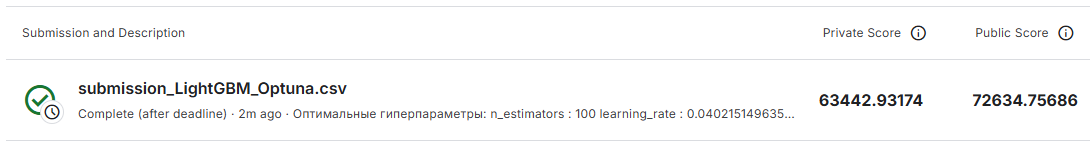

Подбор гиперпараметров LightGBM с помощью Optuna дал **лучшую валидационную метрику RMSE ≈ 67770**, что улучшило результат базовых моделей TabularAutoML и TabularUtilizedAutoML.\
На лидерборде сабмит `submission_LightGBM_Optuna.csv` показал **частный скор 63442.93** против ~63700 у бейзлайна LAMA, то есть тюнинг LightGBM позволил слегка побить AutoML-решение и получить более сильный финальный бейзлайн.